# GloVe Model with 1 Layer

**Layer Sizes**
- H1 = 64

- Glove 50d
- Optimizer : NAdam
- Batch Size = 64
- Learning Rate : 1e-4
- Epochs : 50


DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621

Epoch:   0
(Training) - Loss = 1.28485
(Training) - F1 Score = 0.38581
(Validation) - Loss = 1.03613
(Validation) - F1 Score = 0.48591

Epoch:   1
(Training) - Loss = 1.00293
(Training) - F1 Score = 0.51292
(Validation) - Loss = 0.98830
(Validation) - F1 Score = 0.52316

Epoch:   2
(Training) - Loss = 0.96230
(Training) - F1 Score = 0.53582
(Validation) - Loss = 0.95366
(Validation) - F1 Score = 0.53817

Epoch:   3
(Training) - Loss = 0.93318
(Training) - F1 Score = 0.54674


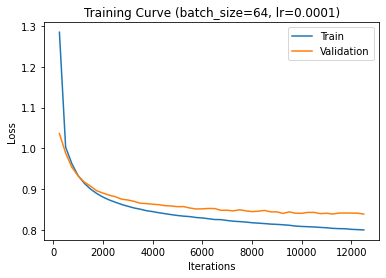

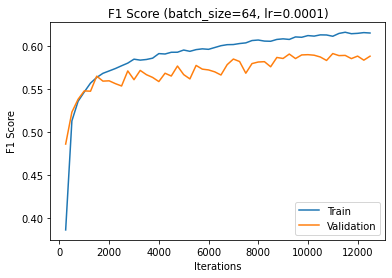

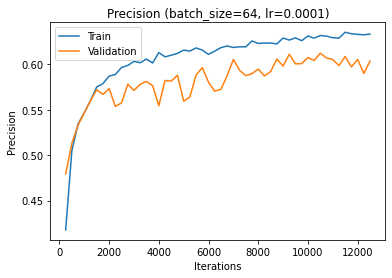

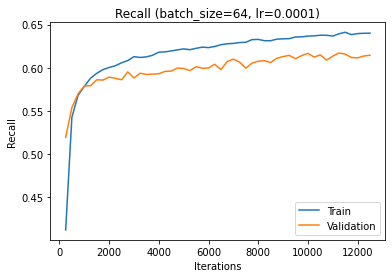

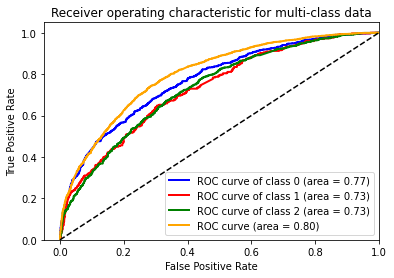

In [2]:
#download glove dataset
!test -f ./glove.6B.50d.txt ||  ( wget http://nlp.stanford.edu/data/wordvecs/glove.6B.zip && unzip glove.6B.zip)
#download adabound
!pip3 install adabound

import re
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import nltk 
import re

from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.feature_extraction.text import  CountVectorizer
from sklearn.feature_extraction.text import  HashingVectorizer
from sklearn import metrics
from sklearn import preprocessing
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from numpy.ma.core import concatenate
from itertools import cycle
from adabound import AdaBound



glove = pd.read_csv('./glove.6B.50d.txt', sep=' ', index_col=0, header=None, quoting=3)
glove_embedding = {key: val.values for key, val in glove.T.items()}



data_train = pd.read_csv('./vaccine_train_set.csv')
data_val = pd.read_csv('./vaccine_validation_set.csv')

x_train = pd.DataFrame(data_train,columns=[data_train.columns[1]])
y_train = pd.DataFrame(data_train,columns=[data_train.columns[2]])

x_val =  pd.DataFrame(data_val,columns=[data_val.columns[1]])
y_val =  pd.DataFrame(data_val,columns=[data_val.columns[2]])

def create_array(tweet): #split tweet into array of its words
    return re.split(' ',tweet)

def transform(tweet):
    array = np.array(np.zeros([1,50]))
    for word in tweet:
        if word not in glove_embedding: #glove does not contain the word in the tweet, fill features with 0
            ar = np.zeros([1,50])
        else:
            ar = np.array([glove_embedding.get(word)]) #fill row features with glove's word embedding
        array = np.concatenate((array,ar)) #concatenate the word embedding with the tweet embedding
    return array

def sum_array(tweet): #sum the array of word embeddings to get the tweet embedding
    return np.sum(tweet, axis=0) 



#create,transform,sum the tweet embedding
#train set
x_train['tweet'] = x_train['tweet'].apply(lambda tweet:create_array(tweet))
x_train['tweet'] = x_train['tweet'].apply(lambda tweet:transform(tweet))
x_train['tweet'] = x_train['tweet'].apply(lambda tweet:sum_array(tweet))

#validation set
x_val['tweet'] = x_val['tweet'].apply(lambda tweet:create_array(tweet))
x_val['tweet'] = x_val['tweet'].apply(lambda tweet:transform(tweet))
x_val['tweet'] = x_val['tweet'].apply(lambda tweet:sum_array(tweet))



#create the train tensor 
x_train = torch.tensor(x_train['tweet'],dtype=torch.float)
k_train = np.array(y_train['label'])

y_train = torch.from_numpy(k_train)
# y_train = y_train.to(torch.long)

#create the validation tensor 
x_val = torch.tensor(x_val['tweet'],dtype=torch.float)
k_val = np.array(y_val['label'])

y_val = torch.from_numpy(k_val)



#Define the NN

class Net(nn.Module):
    def __init__(self, D_in, H1, D_out):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, D_out)

        self.dropout = nn.Dropout(0.7)
        
    def forward(self, x):
        h1 = self.linear1(x)
        act1 =  nn.functional.relu(h1)

        out = self.linear2(act1)
        return out

#Define layer sizes
D_in = x_train.shape[1]
H1 = 64
D_out = 3

#Define Hyperparameters
learning_rate = 0.0001

#Initialize model, loss, optimizer
model = Net(D_in, H1, D_out)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.NAdam(model.parameters(), lr=learning_rate)

#Initialize train dataloader
batch_size = 64
dataset_train = torch.utils.data.TensorDataset(x_train, y_train)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size, shuffle=True)


#Initialize validation dataloader
dataset_val = torch.utils.data.TensorDataset(x_val,y_val)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size, shuffle=True)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)


iterations,losses_train,losses_val,f1ScoresTrain,f1ScoresVal,recallTrain,recallVal,precisionTrain,precisionVal = [],[],[],[],[],[],[],[],[]
n = 0
for epoch in range(50):
  batch_losses_train = []
  batch_losses_val = []
  f1_batch_scores_train,f1_batch_scores_val = [],[]
  precision_batch_train,precision_batch_val = [],[]
  recall_batch_train,recall_batch_val = [],[]

  for x_batch, y_batch in dataloader_train:
    y_pred_train = model(x_batch)
    loss = loss_func(y_pred_train, y_batch)
    batch_losses_train.append(loss.item())

    #Delete previously stored gradients
    optimizer.zero_grad()
    #Perform backpropagation starting from the loss calculated in this epoch
    loss.backward()
    #Update model's weights based on the gradients calculated during backprop
    optimizer.step()
    n += 1

    model.eval()
    model_batch_result = nn.functional.softmax(y_pred_train,dim=1)
    y_pred = model_batch_result.cpu().max(1)[1].numpy()
    f1Score = metrics.f1_score(y_batch,y_pred,average='weighted')
    precision = metrics.precision_score(y_batch,y_pred,average='weighted',zero_division=0)
    recall = metrics.recall_score(y_batch,y_pred,average='weighted',zero_division=0)
    f1_batch_scores_train.append(f1Score)
    precision_batch_train.append(precision)
    recall_batch_train.append(recall)
  
  print(f'\nEpoch: {epoch:3}')
  print(f"(Training) - Loss = {sum(batch_losses_train)/len(dataloader_train):.5f}")
  print(f"(Training) - F1 Score = {sum(f1_batch_scores_train)/len(dataloader_train):.5f}")


  losses_train.append(sum(batch_losses_train)/len(dataloader_train))
  f1ScoresTrain.append(sum(f1_batch_scores_train)/len(dataloader_train))
  precisionTrain.append(sum(precision_batch_train)/len(dataloader_train))
  recallTrain.append(sum(recall_batch_train)/len(dataloader_train))
    

  #evaluate the model on the validation set
  for x_batch,y_batch in dataloader_val:
    y_pred_val = model(x_batch)
    loss_val = loss_func(y_pred_val,y_batch)
    batch_losses_val.append(loss_val.item())

    model.eval()
    model_batch_result = nn.functional.softmax(y_pred_val,dim=1)
    y_pred = model_batch_result.cpu().max(1)[1].numpy()
    f1Score = metrics.f1_score(y_batch,y_pred,average='weighted' )
    precision = metrics.precision_score(y_batch,y_pred,average='weighted',zero_division=0)
    recall = metrics.recall_score(y_batch,y_pred,average='weighted',zero_division=0)
    f1_batch_scores_val.append(f1Score)
    precision_batch_val.append(precision)
    recall_batch_val.append(recall)

  losses_val.append(sum(batch_losses_val)/len(dataloader_val))
  f1ScoresVal.append(sum(f1_batch_scores_val)/len(dataloader_val))
  precisionVal.append(sum(precision_batch_val)/len(dataloader_val))
  recallVal.append(sum(recall_batch_val)/len(dataloader_val))

  print(f"(Validation) - Loss = {sum(batch_losses_val)/len(dataloader_val):.5f}")
  print(f"(Validation) - F1 Score = {sum(f1_batch_scores_val)/len(dataloader_val):.5f}")

  iterations.append(n)
  # scheduler.step()



# Plotting

#Loss
plt.title("Training Curve (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, losses_train, label="Train")
plt.plot(iterations, losses_val, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

#F1 Score
plt.title("F1 Score (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, f1ScoresTrain, label="Train")
plt.plot(iterations, f1ScoresVal, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("F1 Score")
plt.legend(loc='best')
plt.show()

#Precision
plt.title("Precision (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, precisionTrain, label="Train")
plt.plot(iterations, precisionVal, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Precision")
plt.legend(loc='best')
plt.show()

#recall
plt.title("Recall (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, recallTrain, label="Train")
plt.plot(iterations, recallVal, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Recall")
plt.legend(loc='best')
plt.show()


#roc curve
y_val_roc = label_binarize(y_val, classes=[0, 1, 2])
fpr = dict()
tpr = dict()
roc_auc = dict()
y_val_roc = torch.tensor(y_val_roc)

y_pred_val = model(x_val)
sc = nn.functional.softmax(y_pred_val,dim=1)

for i in range(3):
  fpr[i], tpr[i], _ = roc_curve(y_val_roc.detach().numpy()[:, i], sc.detach().numpy()[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

fpr[3], tpr[3], _ = roc_curve(y_val_roc.detach().numpy().ravel(), sc.detach().numpy().ravel())
roc_auc[3] = auc(fpr[3], tpr[3])

colors = cycle(['blue', 'red', 'green','orange'])
for i, color in zip(range(4), colors):
  if(i == 3):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve (area = {0:0.2f})'
             ''.format(roc_auc[i]))
  else:
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()


# GloVe Model with 2 Layers

**Layer Sizes**
- H1 = 128
- H2 = 64

- Glove 50d
- Optimizer : NAdam
- Batch Size = 64
- Learning Rate : 1e-4
- Epochs : 50


DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621

Epoch:   0
(Training) - Loss = 0.98139
(Training) - F1 Score = 0.50652
(Validation) - Loss = 0.93567
(Validation) - F1 Score = 0.53453

Epoch:   1
(Training) - Loss = 0.90522
(Training) - F1 Score = 0.55752
(Validation) - Loss = 0.89769
(Validation) - F1 Score = 0.54435

Epoch:   2
(Training) - Loss = 0.87592
(Training) - F1 Score = 0.57076
(Validation) - Loss = 0.87627
(Validation) - F1 Score = 0.55898

Epoch:   3
(Training) - Loss = 0.85999
(Training) - F1 Score = 0.57853


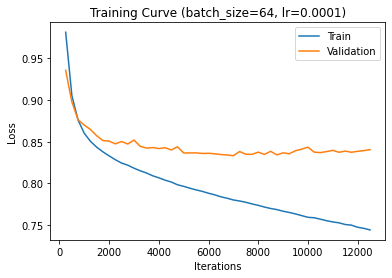

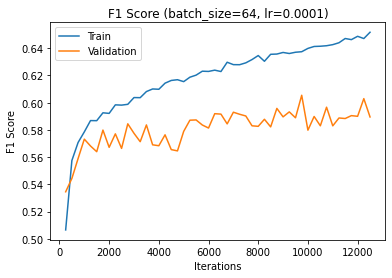

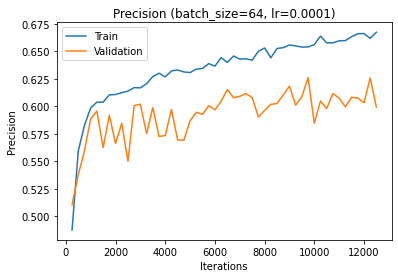

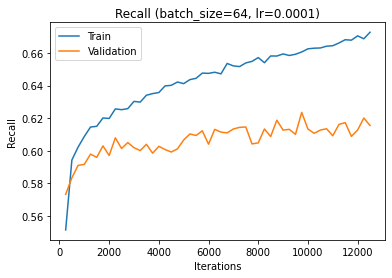

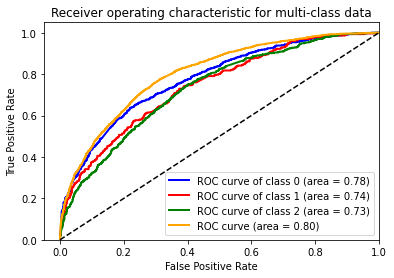

In [5]:
#download glove dataset
!test -f ./glove.6B.50d.txt ||  ( wget http://nlp.stanford.edu/data/wordvecs/glove.6B.zip && unzip glove.6B.zip)
#download adabound
!pip3 install adabound

import re
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import nltk 
import re

from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.feature_extraction.text import  CountVectorizer
from sklearn.feature_extraction.text import  HashingVectorizer
from sklearn import metrics
from sklearn import preprocessing
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from numpy.ma.core import concatenate
from itertools import cycle
from adabound import AdaBound



glove = pd.read_csv('./glove.6B.50d.txt', sep=' ', index_col=0, header=None, quoting=3)
glove_embedding = {key: val.values for key, val in glove.T.items()}



data_train = pd.read_csv('./vaccine_train_set.csv')
data_val = pd.read_csv('./vaccine_validation_set.csv')

x_train = pd.DataFrame(data_train,columns=[data_train.columns[1]])
y_train = pd.DataFrame(data_train,columns=[data_train.columns[2]])

x_val =  pd.DataFrame(data_val,columns=[data_val.columns[1]])
y_val =  pd.DataFrame(data_val,columns=[data_val.columns[2]])

def create_array(tweet): #split tweet into array of its words
    return re.split(' ',tweet)

def transform(tweet):
    array = np.array(np.zeros([1,50]))
    for word in tweet:
        if word not in glove_embedding: #glove does not contain the word in the tweet, fill features with 0
            ar = np.zeros([1,50])
        else:
            ar = np.array([glove_embedding.get(word)]) #fill row features with glove's word embedding
        array = np.concatenate((array,ar)) #concatenate the word embedding with the tweet embedding
    return array

def sum_array(tweet): #sum the array of word embeddings to get the tweet embedding
    return np.sum(tweet, axis=0) 



#create,transform,sum the tweet embedding
#train set
x_train['tweet'] = x_train['tweet'].apply(lambda tweet:create_array(tweet))
x_train['tweet'] = x_train['tweet'].apply(lambda tweet:transform(tweet))
x_train['tweet'] = x_train['tweet'].apply(lambda tweet:sum_array(tweet))

#validation set
x_val['tweet'] = x_val['tweet'].apply(lambda tweet:create_array(tweet))
x_val['tweet'] = x_val['tweet'].apply(lambda tweet:transform(tweet))
x_val['tweet'] = x_val['tweet'].apply(lambda tweet:sum_array(tweet))



#create the train tensor 
x_train = torch.tensor(x_train['tweet'],dtype=torch.float)
k_train = np.array(y_train['label'])

y_train = torch.from_numpy(k_train)
# y_train = y_train.to(torch.long)

#create the validation tensor 
x_val = torch.tensor(x_val['tweet'],dtype=torch.float)
k_val = np.array(y_val['label'])

y_val = torch.from_numpy(k_val)



#Define the NN

class Net(nn.Module):
    def __init__(self, D_in, H1,H2, D_out):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1,H2)
        self.linear3 = nn.Linear(H2, D_out)

        self.dropout = nn.Dropout(0.7)
        
    def forward(self, x):
        h1 = self.linear1(x)
        act1 =  nn.functional.relu(h1)

        h2 = self.linear2(act1)
        act2 =  nn.functional.relu(h2)

        out = self.linear3(act2)
        return out

#Define layer sizes
D_in = x_train.shape[1]
H1 = 128
H2 = 64
D_out = 3

#Define Hyperparameters
learning_rate = 0.0001

#Initialize model, loss, optimizer
model = Net(D_in, H1,H2, D_out)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.NAdam(model.parameters(), lr=learning_rate)

#Initialize train dataloader
batch_size = 64
dataset_train = torch.utils.data.TensorDataset(x_train, y_train)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size, shuffle=True)


#Initialize validation dataloader
dataset_val = torch.utils.data.TensorDataset(x_val,y_val)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size, shuffle=True)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)


iterations,losses_train,losses_val,f1ScoresTrain,f1ScoresVal,recallTrain,recallVal,precisionTrain,precisionVal = [],[],[],[],[],[],[],[],[]
n = 0
for epoch in range(50):
  batch_losses_train = []
  batch_losses_val = []
  f1_batch_scores_train,f1_batch_scores_val = [],[]
  precision_batch_train,precision_batch_val = [],[]
  recall_batch_train,recall_batch_val = [],[]

  for x_batch, y_batch in dataloader_train:
    y_pred_train = model(x_batch)
    loss = loss_func(y_pred_train, y_batch)
    batch_losses_train.append(loss.item())

    #Delete previously stored gradients
    optimizer.zero_grad()
    #Perform backpropagation starting from the loss calculated in this epoch
    loss.backward()
    #Update model's weights based on the gradients calculated during backprop
    optimizer.step()
    n += 1

    model.eval()
    model_batch_result = nn.functional.softmax(y_pred_train,dim=1)
    y_pred = model_batch_result.cpu().max(1)[1].numpy()
    f1Score = metrics.f1_score(y_batch,y_pred,average='weighted')
    precision = metrics.precision_score(y_batch,y_pred,average='weighted',zero_division=0)
    recall = metrics.recall_score(y_batch,y_pred,average='weighted',zero_division=0)
    f1_batch_scores_train.append(f1Score)
    precision_batch_train.append(precision)
    recall_batch_train.append(recall)
  
  print(f'\nEpoch: {epoch:3}')
  print(f"(Training) - Loss = {sum(batch_losses_train)/len(dataloader_train):.5f}")
  print(f"(Training) - F1 Score = {sum(f1_batch_scores_train)/len(dataloader_train):.5f}")


  losses_train.append(sum(batch_losses_train)/len(dataloader_train))
  f1ScoresTrain.append(sum(f1_batch_scores_train)/len(dataloader_train))
  precisionTrain.append(sum(precision_batch_train)/len(dataloader_train))
  recallTrain.append(sum(recall_batch_train)/len(dataloader_train))
    

  #evaluate the model on the validation set
  for x_batch,y_batch in dataloader_val:
    y_pred_val = model(x_batch)
    loss_val = loss_func(y_pred_val,y_batch)
    batch_losses_val.append(loss_val.item())

    model.eval()
    model_batch_result = nn.functional.softmax(y_pred_val,dim=1)
    y_pred = model_batch_result.cpu().max(1)[1].numpy()
    f1Score = metrics.f1_score(y_batch,y_pred,average='weighted' )
    precision = metrics.precision_score(y_batch,y_pred,average='weighted',zero_division=0)
    recall = metrics.recall_score(y_batch,y_pred,average='weighted',zero_division=0)
    f1_batch_scores_val.append(f1Score)
    precision_batch_val.append(precision)
    recall_batch_val.append(recall)

  losses_val.append(sum(batch_losses_val)/len(dataloader_val))
  f1ScoresVal.append(sum(f1_batch_scores_val)/len(dataloader_val))
  precisionVal.append(sum(precision_batch_val)/len(dataloader_val))
  recallVal.append(sum(recall_batch_val)/len(dataloader_val))

  print(f"(Validation) - Loss = {sum(batch_losses_val)/len(dataloader_val):.5f}")
  print(f"(Validation) - F1 Score = {sum(f1_batch_scores_val)/len(dataloader_val):.5f}")

  iterations.append(n)
  # scheduler.step()



# Plotting

#Loss
plt.title("Training Curve (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, losses_train, label="Train")
plt.plot(iterations, losses_val, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

#F1 Score
plt.title("F1 Score (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, f1ScoresTrain, label="Train")
plt.plot(iterations, f1ScoresVal, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("F1 Score")
plt.legend(loc='best')
plt.show()

#Precision
plt.title("Precision (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, precisionTrain, label="Train")
plt.plot(iterations, precisionVal, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Precision")
plt.legend(loc='best')
plt.show()

#recall
plt.title("Recall (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, recallTrain, label="Train")
plt.plot(iterations, recallVal, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Recall")
plt.legend(loc='best')
plt.show()


#roc curve
y_val_roc = label_binarize(y_val, classes=[0, 1, 2])
fpr = dict()
tpr = dict()
roc_auc = dict()
y_val_roc = torch.tensor(y_val_roc)

y_pred_val = model(x_val)
sc = nn.functional.softmax(y_pred_val,dim=1)

for i in range(3):
  fpr[i], tpr[i], _ = roc_curve(y_val_roc.detach().numpy()[:, i], sc.detach().numpy()[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

fpr[3], tpr[3], _ = roc_curve(y_val_roc.detach().numpy().ravel(), sc.detach().numpy().ravel())
roc_auc[3] = auc(fpr[3], tpr[3])

colors = cycle(['blue', 'red', 'green','orange'])
for i, color in zip(range(4), colors):
  if(i == 3):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve (area = {0:0.2f})'
             ''.format(roc_auc[i]))
  else:
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()


# GloVe Model with 3 Layers

**Layer Sizes**
- H1 = 256
- H2 = 128
- H3 = 64

- Glove 50d
- Optimizer : NAdam
- Batch Size = 64
- Learning Rate : 1e-4
- Epochs : 50


In [6]:
#download glove dataset
!test -f ./glove.6B.50d.txt ||  ( wget http://nlp.stanford.edu/data/wordvecs/glove.6B.zip && unzip glove.6B.zip)
#download adabound
!pip3 install adabound

import re
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import nltk 
import re

from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.feature_extraction.text import  CountVectorizer
from sklearn.feature_extraction.text import  HashingVectorizer
from sklearn import metrics
from sklearn import preprocessing
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from numpy.ma.core import concatenate
from itertools import cycle
from adabound import AdaBound



glove = pd.read_csv('./glove.6B.50d.txt', sep=' ', index_col=0, header=None, quoting=3)
glove_embedding = {key: val.values for key, val in glove.T.items()}



data_train = pd.read_csv('./vaccine_train_set.csv')
data_val = pd.read_csv('./vaccine_validation_set.csv')

x_train = pd.DataFrame(data_train,columns=[data_train.columns[1]])
y_train = pd.DataFrame(data_train,columns=[data_train.columns[2]])

x_val =  pd.DataFrame(data_val,columns=[data_val.columns[1]])
y_val =  pd.DataFrame(data_val,columns=[data_val.columns[2]])

def create_array(tweet): #split tweet into array of its words
    return re.split(' ',tweet)

def transform(tweet):
    array = np.array(np.zeros([1,50]))
    for word in tweet:
        if word not in glove_embedding: #glove does not contain the word in the tweet, fill features with 0
            ar = np.zeros([1,50])
        else:
            ar = np.array([glove_embedding.get(word)]) #fill row features with glove's word embedding
        array = np.concatenate((array,ar)) #concatenate the word embedding with the tweet embedding
    return array

def sum_array(tweet): #sum the array of word embeddings to get the tweet embedding
    return np.sum(tweet, axis=0) 



#create,transform,sum the tweet embedding
#train set
x_train['tweet'] = x_train['tweet'].apply(lambda tweet:create_array(tweet))
x_train['tweet'] = x_train['tweet'].apply(lambda tweet:transform(tweet))
x_train['tweet'] = x_train['tweet'].apply(lambda tweet:sum_array(tweet))

#validation set
x_val['tweet'] = x_val['tweet'].apply(lambda tweet:create_array(tweet))
x_val['tweet'] = x_val['tweet'].apply(lambda tweet:transform(tweet))
x_val['tweet'] = x_val['tweet'].apply(lambda tweet:sum_array(tweet))



#create the train tensor 
x_train = torch.tensor(x_train['tweet'],dtype=torch.float)
k_train = np.array(y_train['label'])

y_train = torch.from_numpy(k_train)
# y_train = y_train.to(torch.long)

#create the validation tensor 
x_val = torch.tensor(x_val['tweet'],dtype=torch.float)
k_val = np.array(y_val['label'])

y_val = torch.from_numpy(k_val)



#Define the NN

class Net(nn.Module):
    def __init__(self, D_in, H1,H2,H3, D_out):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1,H2)
        self.linear3 = nn.Linear(H2,H3)
        self.linear4 = nn.Linear(H3, D_out)

        self.dropout = nn.Dropout(0.7)
        
    def forward(self, x):
        h1 = self.linear1(x)
        act1 =  nn.functional.relu(h1)

        h2 = self.linear2(act1)
        act2 =  nn.functional.relu(h2)

        h3 = self.linear3(act2)
        act3 =  nn.functional.relu(h3)

        out = self.linear4(act3)
        return out

#Define layer sizes
D_in = x_train.shape[1]
H1 = 256
H2 = 128
H3 = 64
D_out = 3

#Define Hyperparameters
learning_rate = 0.0001

#Initialize model, loss, optimizer
model = Net(D_in, H1,H2,H3, D_out)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.NAdam(model.parameters(), lr=learning_rate)

#Initialize train dataloader
batch_size = 64
dataset_train = torch.utils.data.TensorDataset(x_train, y_train)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size, shuffle=True)


#Initialize validation dataloader
dataset_val = torch.utils.data.TensorDataset(x_val,y_val)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size, shuffle=True)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)


iterations,losses_train,losses_val,f1ScoresTrain,f1ScoresVal,recallTrain,recallVal,precisionTrain,precisionVal = [],[],[],[],[],[],[],[],[]
n = 0
for epoch in range(50):
  batch_losses_train = []
  batch_losses_val = []
  f1_batch_scores_train,f1_batch_scores_val = [],[]
  precision_batch_train,precision_batch_val = [],[]
  recall_batch_train,recall_batch_val = [],[]

  for x_batch, y_batch in dataloader_train:
    y_pred_train = model(x_batch)
    loss = loss_func(y_pred_train, y_batch)
    batch_losses_train.append(loss.item())

    #Delete previously stored gradients
    optimizer.zero_grad()
    #Perform backpropagation starting from the loss calculated in this epoch
    loss.backward()
    #Update model's weights based on the gradients calculated during backprop
    optimizer.step()
    n += 1

    model.eval()
    model_batch_result = nn.functional.softmax(y_pred_train,dim=1)
    y_pred = model_batch_result.cpu().max(1)[1].numpy()
    f1Score = metrics.f1_score(y_batch,y_pred,average='weighted')
    precision = metrics.precision_score(y_batch,y_pred,average='weighted',zero_division=0)
    recall = metrics.recall_score(y_batch,y_pred,average='weighted',zero_division=0)
    f1_batch_scores_train.append(f1Score)
    precision_batch_train.append(precision)
    recall_batch_train.append(recall)
  
  print(f'\nEpoch: {epoch:3}')
  print(f"(Training) - Loss = {sum(batch_losses_train)/len(dataloader_train):.5f}")
  print(f"(Training) - F1 Score = {sum(f1_batch_scores_train)/len(dataloader_train):.5f}")


  losses_train.append(sum(batch_losses_train)/len(dataloader_train))
  f1ScoresTrain.append(sum(f1_batch_scores_train)/len(dataloader_train))
  precisionTrain.append(sum(precision_batch_train)/len(dataloader_train))
  recallTrain.append(sum(recall_batch_train)/len(dataloader_train))
    

  #evaluate the model on the validation set
  for x_batch,y_batch in dataloader_val:
    y_pred_val = model(x_batch)
    loss_val = loss_func(y_pred_val,y_batch)
    batch_losses_val.append(loss_val.item())

    model.eval()
    model_batch_result = nn.functional.softmax(y_pred_val,dim=1)
    y_pred = model_batch_result.cpu().max(1)[1].numpy()
    f1Score = metrics.f1_score(y_batch,y_pred,average='weighted' )
    precision = metrics.precision_score(y_batch,y_pred,average='weighted',zero_division=0)
    recall = metrics.recall_score(y_batch,y_pred,average='weighted',zero_division=0)
    f1_batch_scores_val.append(f1Score)
    precision_batch_val.append(precision)
    recall_batch_val.append(recall)

  losses_val.append(sum(batch_losses_val)/len(dataloader_val))
  f1ScoresVal.append(sum(f1_batch_scores_val)/len(dataloader_val))
  precisionVal.append(sum(precision_batch_val)/len(dataloader_val))
  recallVal.append(sum(recall_batch_val)/len(dataloader_val))

  print(f"(Validation) - Loss = {sum(batch_losses_val)/len(dataloader_val):.5f}")
  print(f"(Validation) - F1 Score = {sum(f1_batch_scores_val)/len(dataloader_val):.5f}")

  iterations.append(n)
  # scheduler.step()



# Plotting

#Loss
plt.title("Training Curve (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, losses_train, label="Train")
plt.plot(iterations, losses_val, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

#F1 Score
plt.title("F1 Score (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, f1ScoresTrain, label="Train")
plt.plot(iterations, f1ScoresVal, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("F1 Score")
plt.legend(loc='best')
plt.show()

#Precision
plt.title("Precision (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, precisionTrain, label="Train")
plt.plot(iterations, precisionVal, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Precision")
plt.legend(loc='best')
plt.show()

#recall
plt.title("Recall (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, recallTrain, label="Train")
plt.plot(iterations, recallVal, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Recall")
plt.legend(loc='best')
plt.show()


#roc curve
y_val_roc = label_binarize(y_val, classes=[0, 1, 2])
fpr = dict()
tpr = dict()
roc_auc = dict()
y_val_roc = torch.tensor(y_val_roc)

y_pred_val = model(x_val)
sc = nn.functional.softmax(y_pred_val,dim=1)

for i in range(3):
  fpr[i], tpr[i], _ = roc_curve(y_val_roc.detach().numpy()[:, i], sc.detach().numpy()[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

fpr[3], tpr[3], _ = roc_curve(y_val_roc.detach().numpy().ravel(), sc.detach().numpy().ravel())
roc_auc[3] = auc(fpr[3], tpr[3])

colors = cycle(['blue', 'red', 'green','orange'])
for i, color in zip(range(4), colors):
  if(i == 3):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve (area = {0:0.2f})'
             ''.format(roc_auc[i]))
  else:
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()


DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x64 and 128x64)

# GloVe Model with 64 Nodes

**Layer Sizes**
- H1 = 64

- Glove 50d
- Optimizer : NAdam
- Batch Size = 64
- Learning Rate : 1e-4
- Epochs : 50


In [ ]:
#download glove dataset
!test -f ./glove.6B.50d.txt ||  ( wget http://nlp.stanford.edu/data/wordvecs/glove.6B.zip && unzip glove.6B.zip)
#download adabound
!pip3 install adabound

import re
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import nltk 
import re

from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.feature_extraction.text import  CountVectorizer
from sklearn.feature_extraction.text import  HashingVectorizer
from sklearn import metrics
from sklearn import preprocessing
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from numpy.ma.core import concatenate
from itertools import cycle
from adabound import AdaBound



glove = pd.read_csv('./glove.6B.50d.txt', sep=' ', index_col=0, header=None, quoting=3)
glove_embedding = {key: val.values for key, val in glove.T.items()}



data_train = pd.read_csv('./vaccine_train_set.csv')
data_val = pd.read_csv('./vaccine_validation_set.csv')

x_train = pd.DataFrame(data_train,columns=[data_train.columns[1]])
y_train = pd.DataFrame(data_train,columns=[data_train.columns[2]])

x_val =  pd.DataFrame(data_val,columns=[data_val.columns[1]])
y_val =  pd.DataFrame(data_val,columns=[data_val.columns[2]])

def create_array(tweet): #split tweet into array of its words
    return re.split(' ',tweet)

def transform(tweet):
    array = np.array(np.zeros([1,50]))
    for word in tweet:
        if word not in glove_embedding: #glove does not contain the word in the tweet, fill features with 0
            ar = np.zeros([1,50])
        else:
            ar = np.array([glove_embedding.get(word)]) #fill row features with glove's word embedding
        array = np.concatenate((array,ar)) #concatenate the word embedding with the tweet embedding
    return array

def sum_array(tweet): #sum the array of word embeddings to get the tweet embedding
    return np.sum(tweet, axis=0) 



#create,transform,sum the tweet embedding
#train set
x_train['tweet'] = x_train['tweet'].apply(lambda tweet:create_array(tweet))
x_train['tweet'] = x_train['tweet'].apply(lambda tweet:transform(tweet))
x_train['tweet'] = x_train['tweet'].apply(lambda tweet:sum_array(tweet))

#validation set
x_val['tweet'] = x_val['tweet'].apply(lambda tweet:create_array(tweet))
x_val['tweet'] = x_val['tweet'].apply(lambda tweet:transform(tweet))
x_val['tweet'] = x_val['tweet'].apply(lambda tweet:sum_array(tweet))



#create the train tensor 
x_train = torch.tensor(x_train['tweet'],dtype=torch.float)
k_train = np.array(y_train['label'])

y_train = torch.from_numpy(k_train)
# y_train = y_train.to(torch.long)

#create the validation tensor 
x_val = torch.tensor(x_val['tweet'],dtype=torch.float)
k_val = np.array(y_val['label'])

y_val = torch.from_numpy(k_val)



#Define the NN

class Net(nn.Module):
    def __init__(self, D_in, H1, D_out):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, D_out)

        self.dropout = nn.Dropout(0.7)
        
    def forward(self, x):
        h1 = self.linear1(x)
        act1 =  nn.functional.relu(h1)

        out = self.linear2(act1)
        return out

#Define layer sizes
D_in = x_train.shape[1]
H1 = 64
D_out = 3

#Define Hyperparameters
learning_rate = 0.0001

#Initialize model, loss, optimizer
model = Net(D_in, H1, D_out)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.NAdam(model.parameters(), lr=learning_rate)

#Initialize train dataloader
batch_size = 64
dataset_train = torch.utils.data.TensorDataset(x_train, y_train)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size, shuffle=True)


#Initialize validation dataloader
dataset_val = torch.utils.data.TensorDataset(x_val,y_val)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size, shuffle=True)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)


iterations,losses_train,losses_val,f1ScoresTrain,f1ScoresVal,recallTrain,recallVal,precisionTrain,precisionVal = [],[],[],[],[],[],[],[],[]
n = 0
for epoch in range(50):
  batch_losses_train = []
  batch_losses_val = []
  f1_batch_scores_train,f1_batch_scores_val = [],[]
  precision_batch_train,precision_batch_val = [],[]
  recall_batch_train,recall_batch_val = [],[]

  for x_batch, y_batch in dataloader_train:
    y_pred_train = model(x_batch)
    loss = loss_func(y_pred_train, y_batch)
    batch_losses_train.append(loss.item())

    #Delete previously stored gradients
    optimizer.zero_grad()
    #Perform backpropagation starting from the loss calculated in this epoch
    loss.backward()
    #Update model's weights based on the gradients calculated during backprop
    optimizer.step()
    n += 1

    model.eval()
    model_batch_result = nn.functional.softmax(y_pred_train,dim=1)
    y_pred = model_batch_result.cpu().max(1)[1].numpy()
    f1Score = metrics.f1_score(y_batch,y_pred,average='weighted')
    precision = metrics.precision_score(y_batch,y_pred,average='weighted',zero_division=0)
    recall = metrics.recall_score(y_batch,y_pred,average='weighted',zero_division=0)
    f1_batch_scores_train.append(f1Score)
    precision_batch_train.append(precision)
    recall_batch_train.append(recall)
  
  print(f'\nEpoch: {epoch:3}')
  print(f"(Training) - Loss = {sum(batch_losses_train)/len(dataloader_train):.5f}")
  print(f"(Training) - F1 Score = {sum(f1_batch_scores_train)/len(dataloader_train):.5f}")


  losses_train.append(sum(batch_losses_train)/len(dataloader_train))
  f1ScoresTrain.append(sum(f1_batch_scores_train)/len(dataloader_train))
  precisionTrain.append(sum(precision_batch_train)/len(dataloader_train))
  recallTrain.append(sum(recall_batch_train)/len(dataloader_train))
    

  #evaluate the model on the validation set
  for x_batch,y_batch in dataloader_val:
    y_pred_val = model(x_batch)
    loss_val = loss_func(y_pred_val,y_batch)
    batch_losses_val.append(loss_val.item())

    model.eval()
    model_batch_result = nn.functional.softmax(y_pred_val,dim=1)
    y_pred = model_batch_result.cpu().max(1)[1].numpy()
    f1Score = metrics.f1_score(y_batch,y_pred,average='weighted' )
    precision = metrics.precision_score(y_batch,y_pred,average='weighted',zero_division=0)
    recall = metrics.recall_score(y_batch,y_pred,average='weighted',zero_division=0)
    f1_batch_scores_val.append(f1Score)
    precision_batch_val.append(precision)
    recall_batch_val.append(recall)

  losses_val.append(sum(batch_losses_val)/len(dataloader_val))
  f1ScoresVal.append(sum(f1_batch_scores_val)/len(dataloader_val))
  precisionVal.append(sum(precision_batch_val)/len(dataloader_val))
  recallVal.append(sum(recall_batch_val)/len(dataloader_val))

  print(f"(Validation) - Loss = {sum(batch_losses_val)/len(dataloader_val):.5f}")
  print(f"(Validation) - F1 Score = {sum(f1_batch_scores_val)/len(dataloader_val):.5f}")

  iterations.append(n)
  # scheduler.step()



# Plotting

#Loss
plt.title("Training Curve (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, losses_train, label="Train")
plt.plot(iterations, losses_val, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

#F1 Score
plt.title("F1 Score (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, f1ScoresTrain, label="Train")
plt.plot(iterations, f1ScoresVal, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("F1 Score")
plt.legend(loc='best')
plt.show()

#Precision
plt.title("Precision (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, precisionTrain, label="Train")
plt.plot(iterations, precisionVal, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Precision")
plt.legend(loc='best')
plt.show()

#recall
plt.title("Recall (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, recallTrain, label="Train")
plt.plot(iterations, recallVal, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Recall")
plt.legend(loc='best')
plt.show()


#roc curve
y_val_roc = label_binarize(y_val, classes=[0, 1, 2])
fpr = dict()
tpr = dict()
roc_auc = dict()
y_val_roc = torch.tensor(y_val_roc)

y_pred_val = model(x_val)
sc = nn.functional.softmax(y_pred_val,dim=1)

for i in range(3):
  fpr[i], tpr[i], _ = roc_curve(y_val_roc.detach().numpy()[:, i], sc.detach().numpy()[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

fpr[3], tpr[3], _ = roc_curve(y_val_roc.detach().numpy().ravel(), sc.detach().numpy().ravel())
roc_auc[3] = auc(fpr[3], tpr[3])

colors = cycle(['blue', 'red', 'green','orange'])
for i, color in zip(range(4), colors):
  if(i == 3):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve (area = {0:0.2f})'
             ''.format(roc_auc[i]))
  else:
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()


# GloVe Model with 512 Nodes

**Layer Sizes**
- H1 = 512

- Glove 50d
- Optimizer : NAdam
- Batch Size = 64
- Learning Rate : 1e-4
- Epochs : 50


DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


/var/folders/v9/0g473_2s1_7d8mjnpg8tx86r0000gn/T/ipykernel_1493/3067626686.py:76: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  x_train = torch.tensor(x_train['tweet'],dtype=torch.float)



Epoch:   0
(Training) - Loss = 0.98886
(Training) - F1 Score = 0.50444
(Validation) - Loss = 0.92931
(Validation) - F1 Score = 0.53640

Epoch:   1
(Training) - Loss = 0.90159
(Training) - F1 Score = 0.55718
(Validation) - Loss = 0.88995
(Validation) - F1 Score = 0.56221

Epoch:   2
(Training) - Loss = 0.87369
(Training) - F1 Score = 0.57483
(Validation) - Loss = 0.87133
(Validation) - F1 Score = 0.55748

Epoch:   3
(Training) - Loss = 0.85938
(Training) - F1 Score = 0.58365
(Validation) - Loss = 0.86355
(Validation) - F1 Score = 0.57004

Epoch:   4
(Training) - Loss = 0.84893
(Training) - F1 Score = 0.58580
(Validation) - Loss = 0.86047
(Validation) - F1 Score = 0.58053

Epoch:   5
(Training) - Loss = 0.84107
(Training) - F1 Score = 0.59237
(Validation) - Loss = 0.86239
(Validation) - F1 Score = 0.56306

Epoch:   6
(Training) - Loss = 0.83464
(Training) - F1 Score = 0.59575
(Validation) - Loss = 0.85338
(Validation) - F1 Score = 0.59716

Epoch:   7
(Training) - Loss = 0.82880
(Trainin

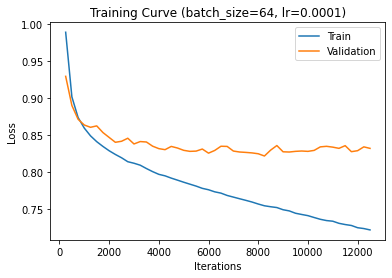

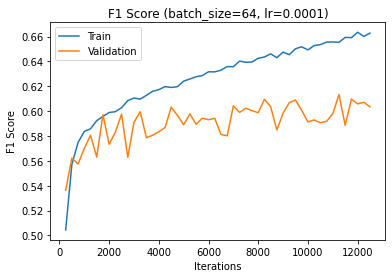

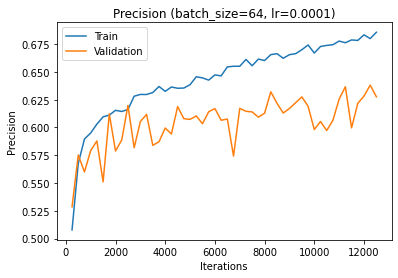

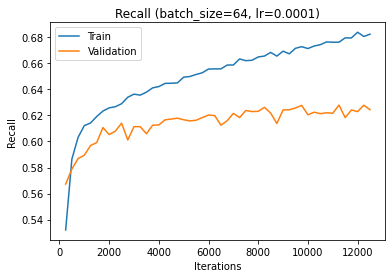

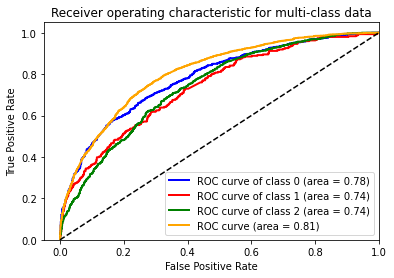

In [ ]:
#download glove dataset
!test -f ./glove.6B.50d.txt ||  ( wget http://nlp.stanford.edu/data/wordvecs/glove.6B.zip && unzip glove.6B.zip)
#download adabound
!pip3 install adabound

import re
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import nltk 
import re

from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.feature_extraction.text import  CountVectorizer
from sklearn.feature_extraction.text import  HashingVectorizer
from sklearn import metrics
from sklearn import preprocessing
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from numpy.ma.core import concatenate
from itertools import cycle
from adabound import AdaBound



glove = pd.read_csv('./glove.6B.50d.txt', sep=' ', index_col=0, header=None, quoting=3)
glove_embedding = {key: val.values for key, val in glove.T.items()}



data_train = pd.read_csv('./vaccine_train_set.csv')
data_val = pd.read_csv('./vaccine_validation_set.csv')

x_train = pd.DataFrame(data_train,columns=[data_train.columns[1]])
y_train = pd.DataFrame(data_train,columns=[data_train.columns[2]])

x_val =  pd.DataFrame(data_val,columns=[data_val.columns[1]])
y_val =  pd.DataFrame(data_val,columns=[data_val.columns[2]])

def create_array(tweet): #split tweet into array of its words
    return re.split(' ',tweet)

def transform(tweet):
    array = np.array(np.zeros([1,50]))
    for word in tweet:
        if word not in glove_embedding: #glove does not contain the word in the tweet, fill features with 0
            ar = np.zeros([1,50])
        else:
            ar = np.array([glove_embedding.get(word)]) #fill row features with glove's word embedding
        array = np.concatenate((array,ar)) #concatenate the word embedding with the tweet embedding
    return array

def sum_array(tweet): #sum the array of word embeddings to get the tweet embedding
    return np.sum(tweet, axis=0) 



#create,transform,sum the tweet embedding
#train set
x_train['tweet'] = x_train['tweet'].apply(lambda tweet:create_array(tweet))
x_train['tweet'] = x_train['tweet'].apply(lambda tweet:transform(tweet))
x_train['tweet'] = x_train['tweet'].apply(lambda tweet:sum_array(tweet))

#validation set
x_val['tweet'] = x_val['tweet'].apply(lambda tweet:create_array(tweet))
x_val['tweet'] = x_val['tweet'].apply(lambda tweet:transform(tweet))
x_val['tweet'] = x_val['tweet'].apply(lambda tweet:sum_array(tweet))



#create the train tensor 
x_train = torch.tensor(x_train['tweet'],dtype=torch.float)
k_train = np.array(y_train['label'])

y_train = torch.from_numpy(k_train)
# y_train = y_train.to(torch.long)

#create the validation tensor 
x_val = torch.tensor(x_val['tweet'],dtype=torch.float)
k_val = np.array(y_val['label'])

y_val = torch.from_numpy(k_val)



#Define the NN

class Net(nn.Module):
    def __init__(self, D_in, H1, D_out):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, D_out)

        self.dropout = nn.Dropout(0.7)
        
    def forward(self, x):
        h1 = self.linear1(x)
        act1 =  nn.functional.relu(h1)

        out = self.linear2(act1)
        return out

#Define layer sizes
D_in = x_train.shape[1]
H1 = 512
D_out = 3

#Define Hyperparameters
learning_rate = 0.0001

#Initialize model, loss, optimizer
model = Net(D_in, H1, D_out)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.NAdam(model.parameters(), lr=learning_rate)

#Initialize train dataloader
batch_size = 64
dataset_train = torch.utils.data.TensorDataset(x_train, y_train)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size, shuffle=True)


#Initialize validation dataloader
dataset_val = torch.utils.data.TensorDataset(x_val,y_val)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size, shuffle=True)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)


iterations,losses_train,losses_val,f1ScoresTrain,f1ScoresVal,recallTrain,recallVal,precisionTrain,precisionVal = [],[],[],[],[],[],[],[],[]
n = 0
for epoch in range(50):
  batch_losses_train = []
  batch_losses_val = []
  f1_batch_scores_train,f1_batch_scores_val = [],[]
  precision_batch_train,precision_batch_val = [],[]
  recall_batch_train,recall_batch_val = [],[]

  for x_batch, y_batch in dataloader_train:
    y_pred_train = model(x_batch)
    loss = loss_func(y_pred_train, y_batch)
    batch_losses_train.append(loss.item())

    #Delete previously stored gradients
    optimizer.zero_grad()
    #Perform backpropagation starting from the loss calculated in this epoch
    loss.backward()
    #Update model's weights based on the gradients calculated during backprop
    optimizer.step()
    n += 1

    model.eval()
    model_batch_result = nn.functional.softmax(y_pred_train,dim=1)
    y_pred = model_batch_result.cpu().max(1)[1].numpy()
    f1Score = metrics.f1_score(y_batch,y_pred,average='weighted')
    precision = metrics.precision_score(y_batch,y_pred,average='weighted',zero_division=0)
    recall = metrics.recall_score(y_batch,y_pred,average='weighted',zero_division=0)
    f1_batch_scores_train.append(f1Score)
    precision_batch_train.append(precision)
    recall_batch_train.append(recall)
  
  print(f'\nEpoch: {epoch:3}')
  print(f"(Training) - Loss = {sum(batch_losses_train)/len(dataloader_train):.5f}")
  print(f"(Training) - F1 Score = {sum(f1_batch_scores_train)/len(dataloader_train):.5f}")


  losses_train.append(sum(batch_losses_train)/len(dataloader_train))
  f1ScoresTrain.append(sum(f1_batch_scores_train)/len(dataloader_train))
  precisionTrain.append(sum(precision_batch_train)/len(dataloader_train))
  recallTrain.append(sum(recall_batch_train)/len(dataloader_train))
    

  #evaluate the model on the validation set
  for x_batch,y_batch in dataloader_val:
    y_pred_val = model(x_batch)
    loss_val = loss_func(y_pred_val,y_batch)
    batch_losses_val.append(loss_val.item())

    model.eval()
    model_batch_result = nn.functional.softmax(y_pred_val,dim=1)
    y_pred = model_batch_result.cpu().max(1)[1].numpy()
    f1Score = metrics.f1_score(y_batch,y_pred,average='weighted' )
    precision = metrics.precision_score(y_batch,y_pred,average='weighted',zero_division=0)
    recall = metrics.recall_score(y_batch,y_pred,average='weighted',zero_division=0)
    f1_batch_scores_val.append(f1Score)
    precision_batch_val.append(precision)
    recall_batch_val.append(recall)

  losses_val.append(sum(batch_losses_val)/len(dataloader_val))
  f1ScoresVal.append(sum(f1_batch_scores_val)/len(dataloader_val))
  precisionVal.append(sum(precision_batch_val)/len(dataloader_val))
  recallVal.append(sum(recall_batch_val)/len(dataloader_val))

  print(f"(Validation) - Loss = {sum(batch_losses_val)/len(dataloader_val):.5f}")
  print(f"(Validation) - F1 Score = {sum(f1_batch_scores_val)/len(dataloader_val):.5f}")

  iterations.append(n)
  # scheduler.step()



# Plotting

#Loss
plt.title("Training Curve (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, losses_train, label="Train")
plt.plot(iterations, losses_val, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

#F1 Score
plt.title("F1 Score (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, f1ScoresTrain, label="Train")
plt.plot(iterations, f1ScoresVal, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("F1 Score")
plt.legend(loc='best')
plt.show()

#Precision
plt.title("Precision (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, precisionTrain, label="Train")
plt.plot(iterations, precisionVal, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Precision")
plt.legend(loc='best')
plt.show()

#recall
plt.title("Recall (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, recallTrain, label="Train")
plt.plot(iterations, recallVal, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Recall")
plt.legend(loc='best')
plt.show()


#roc curve
y_val_roc = label_binarize(y_val, classes=[0, 1, 2])
fpr = dict()
tpr = dict()
roc_auc = dict()
y_val_roc = torch.tensor(y_val_roc)

y_pred_val = model(x_val)
sc = nn.functional.softmax(y_pred_val,dim=1)

for i in range(3):
  fpr[i], tpr[i], _ = roc_curve(y_val_roc.detach().numpy()[:, i], sc.detach().numpy()[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

fpr[3], tpr[3], _ = roc_curve(y_val_roc.detach().numpy().ravel(), sc.detach().numpy().ravel())
roc_auc[3] = auc(fpr[3], tpr[3])

colors = cycle(['blue', 'red', 'green','orange'])
for i, color in zip(range(4), colors):
  if(i == 3):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve (area = {0:0.2f})'
             ''.format(roc_auc[i]))
  else:
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()


# GloVe Model with Learning Rate = 1e-2

**Layer Sizes**
- H1 = 64

- Glove 50d
- Optimizer : NAdam
- Batch Size = 64
- Epochs : 50


DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


/var/folders/v9/0g473_2s1_7d8mjnpg8tx86r0000gn/T/ipykernel_1553/3962332610.py:76: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  x_train = torch.tensor(x_train['tweet'],dtype=torch.float)



Epoch:   0
(Training) - Loss = 0.91550
(Training) - F1 Score = 0.54243
(Validation) - Loss = 1.01647
(Validation) - F1 Score = 0.51632

Epoch:   1
(Training) - Loss = 0.85416
(Training) - F1 Score = 0.57492
(Validation) - Loss = 0.85524
(Validation) - F1 Score = 0.57367

Epoch:   2
(Training) - Loss = 0.83869
(Training) - F1 Score = 0.58506
(Validation) - Loss = 0.86554
(Validation) - F1 Score = 0.55403

Epoch:   3
(Training) - Loss = 0.83315
(Training) - F1 Score = 0.59004
(Validation) - Loss = 0.86344
(Validation) - F1 Score = 0.55486

Epoch:   4
(Training) - Loss = 0.82832
(Training) - F1 Score = 0.59316
(Validation) - Loss = 0.85451
(Validation) - F1 Score = 0.57536

Epoch:   5
(Training) - Loss = 0.82245
(Training) - F1 Score = 0.60035
(Validation) - Loss = 0.85676
(Validation) - F1 Score = 0.56664

Epoch:   6
(Training) - Loss = 0.81786
(Training) - F1 Score = 0.60126
(Validation) - Loss = 0.85389
(Validation) - F1 Score = 0.57949

Epoch:   7
(Training) - Loss = 0.81192
(Trainin

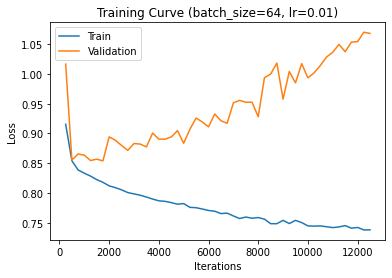

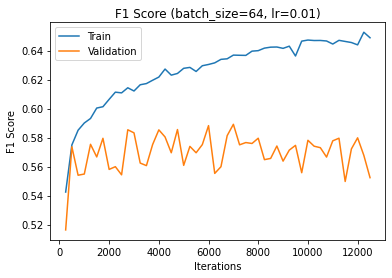

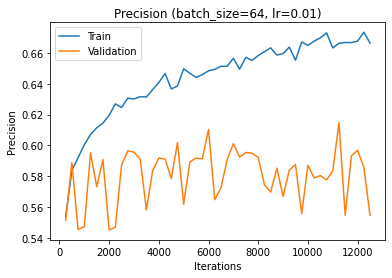

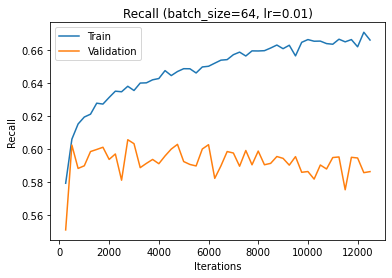

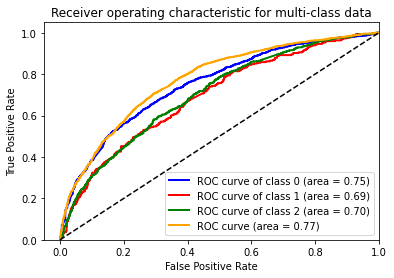

In [ ]:
#download glove dataset
!test -f ./glove.6B.50d.txt ||  ( wget http://nlp.stanford.edu/data/wordvecs/glove.6B.zip && unzip glove.6B.zip)
#download adabound
!pip3 install adabound

import re
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import nltk 
import re

from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.feature_extraction.text import  CountVectorizer
from sklearn.feature_extraction.text import  HashingVectorizer
from sklearn import metrics
from sklearn import preprocessing
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from numpy.ma.core import concatenate
from itertools import cycle
from adabound import AdaBound



glove = pd.read_csv('./glove.6B.50d.txt', sep=' ', index_col=0, header=None, quoting=3)
glove_embedding = {key: val.values for key, val in glove.T.items()}



data_train = pd.read_csv('./vaccine_train_set.csv')
data_val = pd.read_csv('./vaccine_validation_set.csv')

x_train = pd.DataFrame(data_train,columns=[data_train.columns[1]])
y_train = pd.DataFrame(data_train,columns=[data_train.columns[2]])

x_val =  pd.DataFrame(data_val,columns=[data_val.columns[1]])
y_val =  pd.DataFrame(data_val,columns=[data_val.columns[2]])

def create_array(tweet): #split tweet into array of its words
    return re.split(' ',tweet)

def transform(tweet):
    array = np.array(np.zeros([1,50]))
    for word in tweet:
        if word not in glove_embedding: #glove does not contain the word in the tweet, fill features with 0
            ar = np.zeros([1,50])
        else:
            ar = np.array([glove_embedding.get(word)]) #fill row features with glove's word embedding
        array = np.concatenate((array,ar)) #concatenate the word embedding with the tweet embedding
    return array

def sum_array(tweet): #sum the array of word embeddings to get the tweet embedding
    return np.sum(tweet, axis=0) 



#create,transform,sum the tweet embedding
#train set
x_train['tweet'] = x_train['tweet'].apply(lambda tweet:create_array(tweet))
x_train['tweet'] = x_train['tweet'].apply(lambda tweet:transform(tweet))
x_train['tweet'] = x_train['tweet'].apply(lambda tweet:sum_array(tweet))

#validation set
x_val['tweet'] = x_val['tweet'].apply(lambda tweet:create_array(tweet))
x_val['tweet'] = x_val['tweet'].apply(lambda tweet:transform(tweet))
x_val['tweet'] = x_val['tweet'].apply(lambda tweet:sum_array(tweet))



#create the train tensor 
x_train = torch.tensor(x_train['tweet'],dtype=torch.float)
k_train = np.array(y_train['label'])

y_train = torch.from_numpy(k_train)
# y_train = y_train.to(torch.long)

#create the validation tensor 
x_val = torch.tensor(x_val['tweet'],dtype=torch.float)
k_val = np.array(y_val['label'])

y_val = torch.from_numpy(k_val)



#Define the NN

class Net(nn.Module):
    def __init__(self, D_in, H1, D_out):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, D_out)

        self.dropout = nn.Dropout(0.7)
        
    def forward(self, x):
        h1 = self.linear1(x)
        act1 =  nn.functional.relu(h1)

        out = self.linear2(act1)
        return out

#Define layer sizes
D_in = x_train.shape[1]
H1 = 64
D_out = 3

#Define Hyperparameters
learning_rate = 0.01

#Initialize model, loss, optimizer
model = Net(D_in, H1, D_out)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.NAdam(model.parameters(), lr=learning_rate)

#Initialize train dataloader
batch_size = 64
dataset_train = torch.utils.data.TensorDataset(x_train, y_train)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size, shuffle=True)


#Initialize validation dataloader
dataset_val = torch.utils.data.TensorDataset(x_val,y_val)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size, shuffle=True)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)


iterations,losses_train,losses_val,f1ScoresTrain,f1ScoresVal,recallTrain,recallVal,precisionTrain,precisionVal = [],[],[],[],[],[],[],[],[]
n = 0
for epoch in range(50):
  batch_losses_train = []
  batch_losses_val = []
  f1_batch_scores_train,f1_batch_scores_val = [],[]
  precision_batch_train,precision_batch_val = [],[]
  recall_batch_train,recall_batch_val = [],[]

  for x_batch, y_batch in dataloader_train:
    y_pred_train = model(x_batch)
    loss = loss_func(y_pred_train, y_batch)
    batch_losses_train.append(loss.item())

    #Delete previously stored gradients
    optimizer.zero_grad()
    #Perform backpropagation starting from the loss calculated in this epoch
    loss.backward()
    #Update model's weights based on the gradients calculated during backprop
    optimizer.step()
    n += 1

    model.eval()
    model_batch_result = nn.functional.softmax(y_pred_train,dim=1)
    y_pred = model_batch_result.cpu().max(1)[1].numpy()
    f1Score = metrics.f1_score(y_batch,y_pred,average='weighted')
    precision = metrics.precision_score(y_batch,y_pred,average='weighted',zero_division=0)
    recall = metrics.recall_score(y_batch,y_pred,average='weighted',zero_division=0)
    f1_batch_scores_train.append(f1Score)
    precision_batch_train.append(precision)
    recall_batch_train.append(recall)
  
  print(f'\nEpoch: {epoch:3}')
  print(f"(Training) - Loss = {sum(batch_losses_train)/len(dataloader_train):.5f}")
  print(f"(Training) - F1 Score = {sum(f1_batch_scores_train)/len(dataloader_train):.5f}")


  losses_train.append(sum(batch_losses_train)/len(dataloader_train))
  f1ScoresTrain.append(sum(f1_batch_scores_train)/len(dataloader_train))
  precisionTrain.append(sum(precision_batch_train)/len(dataloader_train))
  recallTrain.append(sum(recall_batch_train)/len(dataloader_train))
    

  #evaluate the model on the validation set
  for x_batch,y_batch in dataloader_val:
    y_pred_val = model(x_batch)
    loss_val = loss_func(y_pred_val,y_batch)
    batch_losses_val.append(loss_val.item())

    model.eval()
    model_batch_result = nn.functional.softmax(y_pred_val,dim=1)
    y_pred = model_batch_result.cpu().max(1)[1].numpy()
    f1Score = metrics.f1_score(y_batch,y_pred,average='weighted' )
    precision = metrics.precision_score(y_batch,y_pred,average='weighted',zero_division=0)
    recall = metrics.recall_score(y_batch,y_pred,average='weighted',zero_division=0)
    f1_batch_scores_val.append(f1Score)
    precision_batch_val.append(precision)
    recall_batch_val.append(recall)

  losses_val.append(sum(batch_losses_val)/len(dataloader_val))
  f1ScoresVal.append(sum(f1_batch_scores_val)/len(dataloader_val))
  precisionVal.append(sum(precision_batch_val)/len(dataloader_val))
  recallVal.append(sum(recall_batch_val)/len(dataloader_val))

  print(f"(Validation) - Loss = {sum(batch_losses_val)/len(dataloader_val):.5f}")
  print(f"(Validation) - F1 Score = {sum(f1_batch_scores_val)/len(dataloader_val):.5f}")

  iterations.append(n)
  # scheduler.step()



# Plotting

#Loss
plt.title("Training Curve (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, losses_train, label="Train")
plt.plot(iterations, losses_val, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

#F1 Score
plt.title("F1 Score (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, f1ScoresTrain, label="Train")
plt.plot(iterations, f1ScoresVal, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("F1 Score")
plt.legend(loc='best')
plt.show()

#Precision
plt.title("Precision (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, precisionTrain, label="Train")
plt.plot(iterations, precisionVal, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Precision")
plt.legend(loc='best')
plt.show()

#recall
plt.title("Recall (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, recallTrain, label="Train")
plt.plot(iterations, recallVal, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Recall")
plt.legend(loc='best')
plt.show()


#roc curve
y_val_roc = label_binarize(y_val, classes=[0, 1, 2])
fpr = dict()
tpr = dict()
roc_auc = dict()
y_val_roc = torch.tensor(y_val_roc)

y_pred_val = model(x_val)
sc = nn.functional.softmax(y_pred_val,dim=1)

for i in range(3):
  fpr[i], tpr[i], _ = roc_curve(y_val_roc.detach().numpy()[:, i], sc.detach().numpy()[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

fpr[3], tpr[3], _ = roc_curve(y_val_roc.detach().numpy().ravel(), sc.detach().numpy().ravel())
roc_auc[3] = auc(fpr[3], tpr[3])

colors = cycle(['blue', 'red', 'green','orange'])
for i, color in zip(range(4), colors):
  if(i == 3):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve (area = {0:0.2f})'
             ''.format(roc_auc[i]))
  else:
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()


# GloVe Model with Learning Rate = 1e-3

**Layer Sizes**
- H1 = 64

- Glove 50d
- Optimizer : NAdam
- Batch Size = 64
- Epochs : 50


DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


/var/folders/v9/0g473_2s1_7d8mjnpg8tx86r0000gn/T/ipykernel_1540/246259765.py:76: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  x_train = torch.tensor(x_train['tweet'],dtype=torch.float)



Epoch:   0
(Training) - Loss = 0.97890
(Training) - F1 Score = 0.51968
(Validation) - Loss = 0.89688
(Validation) - F1 Score = 0.56631

Epoch:   1
(Training) - Loss = 0.87015
(Training) - F1 Score = 0.57332
(Validation) - Loss = 0.88087
(Validation) - F1 Score = 0.57340

Epoch:   2
(Training) - Loss = 0.84932
(Training) - F1 Score = 0.58498
(Validation) - Loss = 0.87220
(Validation) - F1 Score = 0.58900

Epoch:   3
(Training) - Loss = 0.83550
(Training) - F1 Score = 0.59307
(Validation) - Loss = 0.85097
(Validation) - F1 Score = 0.57313

Epoch:   4
(Training) - Loss = 0.82452
(Training) - F1 Score = 0.59838
(Validation) - Loss = 0.85687
(Validation) - F1 Score = 0.55981

Epoch:   5
(Training) - Loss = 0.81993
(Training) - F1 Score = 0.60129
(Validation) - Loss = 0.84374
(Validation) - F1 Score = 0.56781

Epoch:   6
(Training) - Loss = 0.81162
(Training) - F1 Score = 0.60640
(Validation) - Loss = 0.84501
(Validation) - F1 Score = 0.58058

Epoch:   7
(Training) - Loss = 0.80763
(Trainin

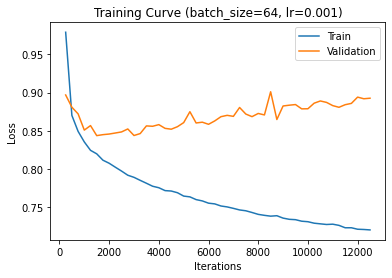

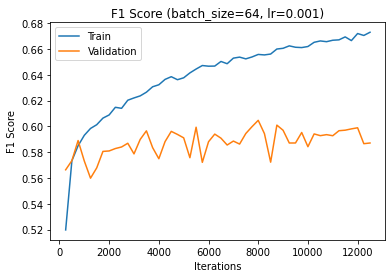

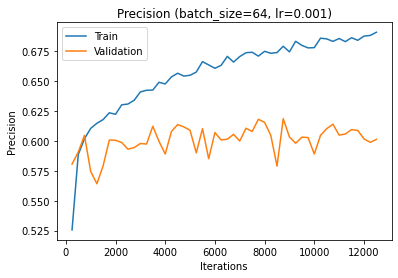

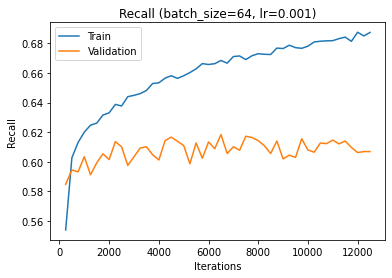

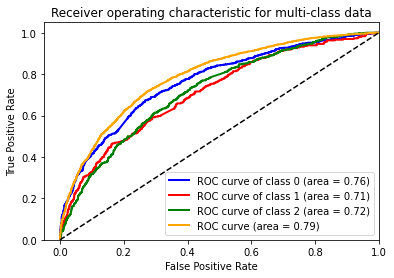

In [ ]:
#download glove dataset
!test -f ./glove.6B.50d.txt ||  ( wget http://nlp.stanford.edu/data/wordvecs/glove.6B.zip && unzip glove.6B.zip)
#download adabound
!pip3 install adabound

import re
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import nltk 
import re

from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.feature_extraction.text import  CountVectorizer
from sklearn.feature_extraction.text import  HashingVectorizer
from sklearn import metrics
from sklearn import preprocessing
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from numpy.ma.core import concatenate
from itertools import cycle
from adabound import AdaBound



glove = pd.read_csv('./glove.6B.50d.txt', sep=' ', index_col=0, header=None, quoting=3)
glove_embedding = {key: val.values for key, val in glove.T.items()}



data_train = pd.read_csv('./vaccine_train_set.csv')
data_val = pd.read_csv('./vaccine_validation_set.csv')

x_train = pd.DataFrame(data_train,columns=[data_train.columns[1]])
y_train = pd.DataFrame(data_train,columns=[data_train.columns[2]])

x_val =  pd.DataFrame(data_val,columns=[data_val.columns[1]])
y_val =  pd.DataFrame(data_val,columns=[data_val.columns[2]])

def create_array(tweet): #split tweet into array of its words
    return re.split(' ',tweet)

def transform(tweet):
    array = np.array(np.zeros([1,50]))
    for word in tweet:
        if word not in glove_embedding: #glove does not contain the word in the tweet, fill features with 0
            ar = np.zeros([1,50])
        else:
            ar = np.array([glove_embedding.get(word)]) #fill row features with glove's word embedding
        array = np.concatenate((array,ar)) #concatenate the word embedding with the tweet embedding
    return array

def sum_array(tweet): #sum the array of word embeddings to get the tweet embedding
    return np.sum(tweet, axis=0) 



#create,transform,sum the tweet embedding
#train set
x_train['tweet'] = x_train['tweet'].apply(lambda tweet:create_array(tweet))
x_train['tweet'] = x_train['tweet'].apply(lambda tweet:transform(tweet))
x_train['tweet'] = x_train['tweet'].apply(lambda tweet:sum_array(tweet))

#validation set
x_val['tweet'] = x_val['tweet'].apply(lambda tweet:create_array(tweet))
x_val['tweet'] = x_val['tweet'].apply(lambda tweet:transform(tweet))
x_val['tweet'] = x_val['tweet'].apply(lambda tweet:sum_array(tweet))



#create the train tensor 
x_train = torch.tensor(x_train['tweet'],dtype=torch.float)
k_train = np.array(y_train['label'])

y_train = torch.from_numpy(k_train)
# y_train = y_train.to(torch.long)

#create the validation tensor 
x_val = torch.tensor(x_val['tweet'],dtype=torch.float)
k_val = np.array(y_val['label'])

y_val = torch.from_numpy(k_val)



#Define the NN

class Net(nn.Module):
    def __init__(self, D_in, H1, D_out):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, D_out)

        self.dropout = nn.Dropout(0.7)
        
    def forward(self, x):
        h1 = self.linear1(x)
        act1 =  nn.functional.relu(h1)

        out = self.linear2(act1)
        return out

#Define layer sizes
D_in = x_train.shape[1]
H1 = 64
D_out = 3

#Define Hyperparameters
learning_rate = 0.001

#Initialize model, loss, optimizer
model = Net(D_in, H1, D_out)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.NAdam(model.parameters(), lr=learning_rate)

#Initialize train dataloader
batch_size = 64
dataset_train = torch.utils.data.TensorDataset(x_train, y_train)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size, shuffle=True)


#Initialize validation dataloader
dataset_val = torch.utils.data.TensorDataset(x_val,y_val)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size, shuffle=True)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)


iterations,losses_train,losses_val,f1ScoresTrain,f1ScoresVal,recallTrain,recallVal,precisionTrain,precisionVal = [],[],[],[],[],[],[],[],[]
n = 0
for epoch in range(50):
  batch_losses_train = []
  batch_losses_val = []
  f1_batch_scores_train,f1_batch_scores_val = [],[]
  precision_batch_train,precision_batch_val = [],[]
  recall_batch_train,recall_batch_val = [],[]

  for x_batch, y_batch in dataloader_train:
    y_pred_train = model(x_batch)
    loss = loss_func(y_pred_train, y_batch)
    batch_losses_train.append(loss.item())

    #Delete previously stored gradients
    optimizer.zero_grad()
    #Perform backpropagation starting from the loss calculated in this epoch
    loss.backward()
    #Update model's weights based on the gradients calculated during backprop
    optimizer.step()
    n += 1

    model.eval()
    model_batch_result = nn.functional.softmax(y_pred_train,dim=1)
    y_pred = model_batch_result.cpu().max(1)[1].numpy()
    f1Score = metrics.f1_score(y_batch,y_pred,average='weighted')
    precision = metrics.precision_score(y_batch,y_pred,average='weighted',zero_division=0)
    recall = metrics.recall_score(y_batch,y_pred,average='weighted',zero_division=0)
    f1_batch_scores_train.append(f1Score)
    precision_batch_train.append(precision)
    recall_batch_train.append(recall)
  
  print(f'\nEpoch: {epoch:3}')
  print(f"(Training) - Loss = {sum(batch_losses_train)/len(dataloader_train):.5f}")
  print(f"(Training) - F1 Score = {sum(f1_batch_scores_train)/len(dataloader_train):.5f}")


  losses_train.append(sum(batch_losses_train)/len(dataloader_train))
  f1ScoresTrain.append(sum(f1_batch_scores_train)/len(dataloader_train))
  precisionTrain.append(sum(precision_batch_train)/len(dataloader_train))
  recallTrain.append(sum(recall_batch_train)/len(dataloader_train))
    

  #evaluate the model on the validation set
  for x_batch,y_batch in dataloader_val:
    y_pred_val = model(x_batch)
    loss_val = loss_func(y_pred_val,y_batch)
    batch_losses_val.append(loss_val.item())

    model.eval()
    model_batch_result = nn.functional.softmax(y_pred_val,dim=1)
    y_pred = model_batch_result.cpu().max(1)[1].numpy()
    f1Score = metrics.f1_score(y_batch,y_pred,average='weighted' )
    precision = metrics.precision_score(y_batch,y_pred,average='weighted',zero_division=0)
    recall = metrics.recall_score(y_batch,y_pred,average='weighted',zero_division=0)
    f1_batch_scores_val.append(f1Score)
    precision_batch_val.append(precision)
    recall_batch_val.append(recall)

  losses_val.append(sum(batch_losses_val)/len(dataloader_val))
  f1ScoresVal.append(sum(f1_batch_scores_val)/len(dataloader_val))
  precisionVal.append(sum(precision_batch_val)/len(dataloader_val))
  recallVal.append(sum(recall_batch_val)/len(dataloader_val))

  print(f"(Validation) - Loss = {sum(batch_losses_val)/len(dataloader_val):.5f}")
  print(f"(Validation) - F1 Score = {sum(f1_batch_scores_val)/len(dataloader_val):.5f}")

  iterations.append(n)
  # scheduler.step()



# Plotting

#Loss
plt.title("Training Curve (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, losses_train, label="Train")
plt.plot(iterations, losses_val, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

#F1 Score
plt.title("F1 Score (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, f1ScoresTrain, label="Train")
plt.plot(iterations, f1ScoresVal, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("F1 Score")
plt.legend(loc='best')
plt.show()

#Precision
plt.title("Precision (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, precisionTrain, label="Train")
plt.plot(iterations, precisionVal, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Precision")
plt.legend(loc='best')
plt.show()

#recall
plt.title("Recall (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, recallTrain, label="Train")
plt.plot(iterations, recallVal, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Recall")
plt.legend(loc='best')
plt.show()


#roc curve
y_val_roc = label_binarize(y_val, classes=[0, 1, 2])
fpr = dict()
tpr = dict()
roc_auc = dict()
y_val_roc = torch.tensor(y_val_roc)

y_pred_val = model(x_val)
sc = nn.functional.softmax(y_pred_val,dim=1)

for i in range(3):
  fpr[i], tpr[i], _ = roc_curve(y_val_roc.detach().numpy()[:, i], sc.detach().numpy()[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

fpr[3], tpr[3], _ = roc_curve(y_val_roc.detach().numpy().ravel(), sc.detach().numpy().ravel())
roc_auc[3] = auc(fpr[3], tpr[3])

colors = cycle(['blue', 'red', 'green','orange'])
for i, color in zip(range(4), colors):
  if(i == 3):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve (area = {0:0.2f})'
             ''.format(roc_auc[i]))
  else:
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()


# GloVe Model with Learning Rate = 1e-4

**Layer Sizes**
- H1 = 64

- Glove 50d
- Optimizer : NAdam
- Batch Size = 64
- Epochs : 50


In [ ]:
#download glove dataset
!test -f ./glove.6B.50d.txt ||  ( wget http://nlp.stanford.edu/data/wordvecs/glove.6B.zip && unzip glove.6B.zip)
#download adabound
!pip3 install adabound

import re
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import nltk 
import re

from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.feature_extraction.text import  CountVectorizer
from sklearn.feature_extraction.text import  HashingVectorizer
from sklearn import metrics
from sklearn import preprocessing
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from numpy.ma.core import concatenate
from itertools import cycle
from adabound import AdaBound



glove = pd.read_csv('./glove.6B.50d.txt', sep=' ', index_col=0, header=None, quoting=3)
glove_embedding = {key: val.values for key, val in glove.T.items()}



data_train = pd.read_csv('./vaccine_train_set.csv')
data_val = pd.read_csv('./vaccine_validation_set.csv')

x_train = pd.DataFrame(data_train,columns=[data_train.columns[1]])
y_train = pd.DataFrame(data_train,columns=[data_train.columns[2]])

x_val =  pd.DataFrame(data_val,columns=[data_val.columns[1]])
y_val =  pd.DataFrame(data_val,columns=[data_val.columns[2]])

def create_array(tweet): #split tweet into array of its words
    return re.split(' ',tweet)

def transform(tweet):
    array = np.array(np.zeros([1,50]))
    for word in tweet:
        if word not in glove_embedding: #glove does not contain the word in the tweet, fill features with 0
            ar = np.zeros([1,50])
        else:
            ar = np.array([glove_embedding.get(word)]) #fill row features with glove's word embedding
        array = np.concatenate((array,ar)) #concatenate the word embedding with the tweet embedding
    return array

def sum_array(tweet): #sum the array of word embeddings to get the tweet embedding
    return np.sum(tweet, axis=0) 



#create,transform,sum the tweet embedding
#train set
x_train['tweet'] = x_train['tweet'].apply(lambda tweet:create_array(tweet))
x_train['tweet'] = x_train['tweet'].apply(lambda tweet:transform(tweet))
x_train['tweet'] = x_train['tweet'].apply(lambda tweet:sum_array(tweet))

#validation set
x_val['tweet'] = x_val['tweet'].apply(lambda tweet:create_array(tweet))
x_val['tweet'] = x_val['tweet'].apply(lambda tweet:transform(tweet))
x_val['tweet'] = x_val['tweet'].apply(lambda tweet:sum_array(tweet))



#create the train tensor 
x_train = torch.tensor(x_train['tweet'],dtype=torch.float)
k_train = np.array(y_train['label'])

y_train = torch.from_numpy(k_train)
# y_train = y_train.to(torch.long)

#create the validation tensor 
x_val = torch.tensor(x_val['tweet'],dtype=torch.float)
k_val = np.array(y_val['label'])

y_val = torch.from_numpy(k_val)



#Define the NN

class Net(nn.Module):
    def __init__(self, D_in, H1, D_out):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, D_out)

        self.dropout = nn.Dropout(0.7)
        
    def forward(self, x):
        h1 = self.linear1(x)
        act1 =  nn.functional.relu(h1)

        out = self.linear2(act1)
        return out

#Define layer sizes
D_in = x_train.shape[1]
H1 = 64
D_out = 3

#Define Hyperparameters
learning_rate = 0.0001

#Initialize model, loss, optimizer
model = Net(D_in, H1, D_out)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.NAdam(model.parameters(), lr=learning_rate)

#Initialize train dataloader
batch_size = 64
dataset_train = torch.utils.data.TensorDataset(x_train, y_train)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size, shuffle=True)


#Initialize validation dataloader
dataset_val = torch.utils.data.TensorDataset(x_val,y_val)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size, shuffle=True)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)


iterations,losses_train,losses_val,f1ScoresTrain,f1ScoresVal,recallTrain,recallVal,precisionTrain,precisionVal = [],[],[],[],[],[],[],[],[]
n = 0
for epoch in range(50):
  batch_losses_train = []
  batch_losses_val = []
  f1_batch_scores_train,f1_batch_scores_val = [],[]
  precision_batch_train,precision_batch_val = [],[]
  recall_batch_train,recall_batch_val = [],[]

  for x_batch, y_batch in dataloader_train:
    y_pred_train = model(x_batch)
    loss = loss_func(y_pred_train, y_batch)
    batch_losses_train.append(loss.item())

    #Delete previously stored gradients
    optimizer.zero_grad()
    #Perform backpropagation starting from the loss calculated in this epoch
    loss.backward()
    #Update model's weights based on the gradients calculated during backprop
    optimizer.step()
    n += 1

    model.eval()
    model_batch_result = nn.functional.softmax(y_pred_train,dim=1)
    y_pred = model_batch_result.cpu().max(1)[1].numpy()
    f1Score = metrics.f1_score(y_batch,y_pred,average='weighted')
    precision = metrics.precision_score(y_batch,y_pred,average='weighted',zero_division=0)
    recall = metrics.recall_score(y_batch,y_pred,average='weighted',zero_division=0)
    f1_batch_scores_train.append(f1Score)
    precision_batch_train.append(precision)
    recall_batch_train.append(recall)
  
  print(f'\nEpoch: {epoch:3}')
  print(f"(Training) - Loss = {sum(batch_losses_train)/len(dataloader_train):.5f}")
  print(f"(Training) - F1 Score = {sum(f1_batch_scores_train)/len(dataloader_train):.5f}")


  losses_train.append(sum(batch_losses_train)/len(dataloader_train))
  f1ScoresTrain.append(sum(f1_batch_scores_train)/len(dataloader_train))
  precisionTrain.append(sum(precision_batch_train)/len(dataloader_train))
  recallTrain.append(sum(recall_batch_train)/len(dataloader_train))
    

  #evaluate the model on the validation set
  for x_batch,y_batch in dataloader_val:
    y_pred_val = model(x_batch)
    loss_val = loss_func(y_pred_val,y_batch)
    batch_losses_val.append(loss_val.item())

    model.eval()
    model_batch_result = nn.functional.softmax(y_pred_val,dim=1)
    y_pred = model_batch_result.cpu().max(1)[1].numpy()
    f1Score = metrics.f1_score(y_batch,y_pred,average='weighted' )
    precision = metrics.precision_score(y_batch,y_pred,average='weighted',zero_division=0)
    recall = metrics.recall_score(y_batch,y_pred,average='weighted',zero_division=0)
    f1_batch_scores_val.append(f1Score)
    precision_batch_val.append(precision)
    recall_batch_val.append(recall)

  losses_val.append(sum(batch_losses_val)/len(dataloader_val))
  f1ScoresVal.append(sum(f1_batch_scores_val)/len(dataloader_val))
  precisionVal.append(sum(precision_batch_val)/len(dataloader_val))
  recallVal.append(sum(recall_batch_val)/len(dataloader_val))

  print(f"(Validation) - Loss = {sum(batch_losses_val)/len(dataloader_val):.5f}")
  print(f"(Validation) - F1 Score = {sum(f1_batch_scores_val)/len(dataloader_val):.5f}")

  iterations.append(n)
  # scheduler.step()



# Plotting

#Loss
plt.title("Training Curve (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, losses_train, label="Train")
plt.plot(iterations, losses_val, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

#F1 Score
plt.title("F1 Score (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, f1ScoresTrain, label="Train")
plt.plot(iterations, f1ScoresVal, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("F1 Score")
plt.legend(loc='best')
plt.show()

#Precision
plt.title("Precision (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, precisionTrain, label="Train")
plt.plot(iterations, precisionVal, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Precision")
plt.legend(loc='best')
plt.show()

#recall
plt.title("Recall (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, recallTrain, label="Train")
plt.plot(iterations, recallVal, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Recall")
plt.legend(loc='best')
plt.show()


#roc curve
y_val_roc = label_binarize(y_val, classes=[0, 1, 2])
fpr = dict()
tpr = dict()
roc_auc = dict()
y_val_roc = torch.tensor(y_val_roc)

y_pred_val = model(x_val)
sc = nn.functional.softmax(y_pred_val,dim=1)

for i in range(3):
  fpr[i], tpr[i], _ = roc_curve(y_val_roc.detach().numpy()[:, i], sc.detach().numpy()[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

fpr[3], tpr[3], _ = roc_curve(y_val_roc.detach().numpy().ravel(), sc.detach().numpy().ravel())
roc_auc[3] = auc(fpr[3], tpr[3])

colors = cycle(['blue', 'red', 'green','orange'])
for i, color in zip(range(4), colors):
  if(i == 3):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve (area = {0:0.2f})'
             ''.format(roc_auc[i]))
  else:
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()


DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


KeyboardInterrupt: 

# GloVe Model with SGD Optimizer 

- Glove 50d
- Optimizer : SGD
- Batch Size = 128
- Learning Rate : 1e-4
- Epochs : 50
- Momentum : 0.8
- Weight Decay : 0.001


DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


/var/folders/v9/0g473_2s1_7d8mjnpg8tx86r0000gn/T/ipykernel_1596/2025376485.py:76: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  x_train = torch.tensor(x_train['tweet'],dtype=torch.float)



Epoch:   0
(Training) - Loss = 1.26520
(Training) - F1 Score = 0.34333
(Validation) - Loss = 1.08811
(Validation) - F1 Score = 0.43670

Epoch:   1
(Training) - Loss = 1.08796
(Training) - F1 Score = 0.44922
(Validation) - Loss = 1.08429
(Validation) - F1 Score = 0.43946

Epoch:   2
(Training) - Loss = 1.08296
(Training) - F1 Score = 0.44944
(Validation) - Loss = 1.07990
(Validation) - F1 Score = 0.44431

Epoch:   3
(Training) - Loss = 1.07873
(Training) - F1 Score = 0.45458
(Validation) - Loss = 1.07612
(Validation) - F1 Score = 0.44648

Epoch:   4
(Training) - Loss = 1.07455
(Training) - F1 Score = 0.45700
(Validation) - Loss = 1.07190
(Validation) - F1 Score = 0.44973

Epoch:   5
(Training) - Loss = 1.07067
(Training) - F1 Score = 0.45983
(Validation) - Loss = 1.06858
(Validation) - F1 Score = 0.45130

Epoch:   6
(Training) - Loss = 1.06677
(Training) - F1 Score = 0.46225
(Validation) - Loss = 1.06525
(Validation) - F1 Score = 0.45319

Epoch:   7
(Training) - Loss = 1.06296
(Trainin

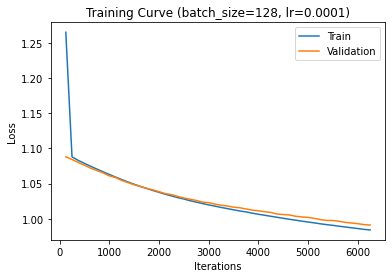

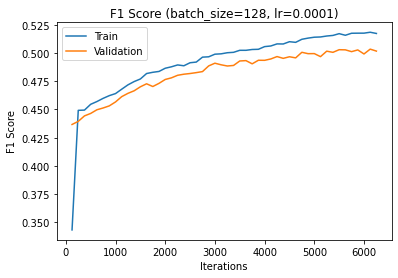

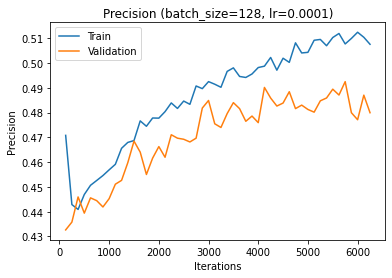

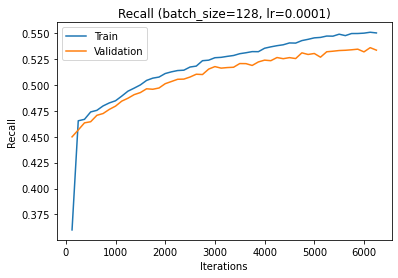

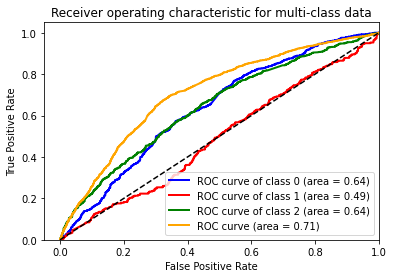

In [ ]:
#download glove dataset
!test -f ./glove.6B.50d.txt ||  ( wget http://nlp.stanford.edu/data/wordvecs/glove.6B.zip && unzip glove.6B.zip)
#download adabound
!pip3 install adabound

import re
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import nltk 
import re

from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.feature_extraction.text import  CountVectorizer
from sklearn.feature_extraction.text import  HashingVectorizer
from sklearn import metrics
from sklearn import preprocessing
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from numpy.ma.core import concatenate
from itertools import cycle
from adabound import AdaBound



glove = pd.read_csv('./glove.6B.50d.txt', sep=' ', index_col=0, header=None, quoting=3)
glove_embedding = {key: val.values for key, val in glove.T.items()}



data_train = pd.read_csv('./vaccine_train_set.csv')
data_val = pd.read_csv('./vaccine_validation_set.csv')

x_train = pd.DataFrame(data_train,columns=[data_train.columns[1]])
y_train = pd.DataFrame(data_train,columns=[data_train.columns[2]])

x_val =  pd.DataFrame(data_val,columns=[data_val.columns[1]])
y_val =  pd.DataFrame(data_val,columns=[data_val.columns[2]])

def create_array(tweet): #split tweet into array of its words
    return re.split(' ',tweet)

def transform(tweet):
    array = np.array(np.zeros([1,50]))
    for word in tweet:
        if word not in glove_embedding: #glove does not contain the word in the tweet, fill features with 0
            ar = np.zeros([1,50])
        else:
            ar = np.array([glove_embedding.get(word)]) #fill row features with glove's word embedding
        array = np.concatenate((array,ar)) #concatenate the word embedding with the tweet embedding
    return array

def sum_array(tweet): #sum the array of word embeddings to get the tweet embedding
    return np.sum(tweet, axis=0) 



#create,transform,sum the tweet embedding
#train set
x_train['tweet'] = x_train['tweet'].apply(lambda tweet:create_array(tweet))
x_train['tweet'] = x_train['tweet'].apply(lambda tweet:transform(tweet))
x_train['tweet'] = x_train['tweet'].apply(lambda tweet:sum_array(tweet))

#validation set
x_val['tweet'] = x_val['tweet'].apply(lambda tweet:create_array(tweet))
x_val['tweet'] = x_val['tweet'].apply(lambda tweet:transform(tweet))
x_val['tweet'] = x_val['tweet'].apply(lambda tweet:sum_array(tweet))



#create the train tensor 
x_train = torch.tensor(x_train['tweet'],dtype=torch.float)
k_train = np.array(y_train['label'])

y_train = torch.from_numpy(k_train)
# y_train = y_train.to(torch.long)

#create the validation tensor 
x_val = torch.tensor(x_val['tweet'],dtype=torch.float)
k_val = np.array(y_val['label'])

y_val = torch.from_numpy(k_val)



#Define the NN

class Net(nn.Module):
    def __init__(self, D_in, H1, D_out):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, D_out)

        self.dropout = nn.Dropout(0.7)
        
    def forward(self, x):
        h1 = self.linear1(x)
        act1 =  nn.functional.relu(h1)

        out = self.linear2(act1)
        return out

#Define layer sizes
D_in = x_train.shape[1]
H1 = 64
D_out = 3

#Define Hyperparameters
learning_rate = 0.0001

#Initialize model, loss, optimizer
model = Net(D_in, H1, D_out)
loss_func = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


#Initialize train dataloader
batch_size = 128
dataset_train = torch.utils.data.TensorDataset(x_train, y_train)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size, shuffle=True)


#Initialize validation dataloader
dataset_val = torch.utils.data.TensorDataset(x_val,y_val)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size, shuffle=True)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)


iterations,losses_train,losses_val,f1ScoresTrain,f1ScoresVal,recallTrain,recallVal,precisionTrain,precisionVal = [],[],[],[],[],[],[],[],[]
n = 0
for epoch in range(50):
  batch_losses_train = []
  batch_losses_val = []
  f1_batch_scores_train,f1_batch_scores_val = [],[]
  precision_batch_train,precision_batch_val = [],[]
  recall_batch_train,recall_batch_val = [],[]

  for x_batch, y_batch in dataloader_train:
    y_pred_train = model(x_batch)
    loss = loss_func(y_pred_train, y_batch)
    batch_losses_train.append(loss.item())

    #Delete previously stored gradients
    optimizer.zero_grad()
    #Perform backpropagation starting from the loss calculated in this epoch
    loss.backward()
    #Update model's weights based on the gradients calculated during backprop
    optimizer.step()
    n += 1

    model.eval()
    model_batch_result = nn.functional.softmax(y_pred_train,dim=1)
    y_pred = model_batch_result.cpu().max(1)[1].numpy()
    f1Score = metrics.f1_score(y_batch,y_pred,average='weighted')
    precision = metrics.precision_score(y_batch,y_pred,average='weighted',zero_division=0)
    recall = metrics.recall_score(y_batch,y_pred,average='weighted',zero_division=0)
    f1_batch_scores_train.append(f1Score)
    precision_batch_train.append(precision)
    recall_batch_train.append(recall)
  
  print(f'\nEpoch: {epoch:3}')
  print(f"(Training) - Loss = {sum(batch_losses_train)/len(dataloader_train):.5f}")
  print(f"(Training) - F1 Score = {sum(f1_batch_scores_train)/len(dataloader_train):.5f}")


  losses_train.append(sum(batch_losses_train)/len(dataloader_train))
  f1ScoresTrain.append(sum(f1_batch_scores_train)/len(dataloader_train))
  precisionTrain.append(sum(precision_batch_train)/len(dataloader_train))
  recallTrain.append(sum(recall_batch_train)/len(dataloader_train))
    

  #evaluate the model on the validation set
  for x_batch,y_batch in dataloader_val:
    y_pred_val = model(x_batch)
    loss_val = loss_func(y_pred_val,y_batch)
    batch_losses_val.append(loss_val.item())

    model.eval()
    model_batch_result = nn.functional.softmax(y_pred_val,dim=1)
    y_pred = model_batch_result.cpu().max(1)[1].numpy()
    f1Score = metrics.f1_score(y_batch,y_pred,average='weighted' )
    precision = metrics.precision_score(y_batch,y_pred,average='weighted',zero_division=0)
    recall = metrics.recall_score(y_batch,y_pred,average='weighted',zero_division=0)
    f1_batch_scores_val.append(f1Score)
    precision_batch_val.append(precision)
    recall_batch_val.append(recall)

  losses_val.append(sum(batch_losses_val)/len(dataloader_val))
  f1ScoresVal.append(sum(f1_batch_scores_val)/len(dataloader_val))
  precisionVal.append(sum(precision_batch_val)/len(dataloader_val))
  recallVal.append(sum(recall_batch_val)/len(dataloader_val))

  print(f"(Validation) - Loss = {sum(batch_losses_val)/len(dataloader_val):.5f}")
  print(f"(Validation) - F1 Score = {sum(f1_batch_scores_val)/len(dataloader_val):.5f}")

  iterations.append(n)
  # scheduler.step()



# Plotting

#Loss
plt.title("Training Curve (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, losses_train, label="Train")
plt.plot(iterations, losses_val, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

#F1 Score
plt.title("F1 Score (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, f1ScoresTrain, label="Train")
plt.plot(iterations, f1ScoresVal, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("F1 Score")
plt.legend(loc='best')
plt.show()

#Precision
plt.title("Precision (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, precisionTrain, label="Train")
plt.plot(iterations, precisionVal, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Precision")
plt.legend(loc='best')
plt.show()

#recall
plt.title("Recall (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, recallTrain, label="Train")
plt.plot(iterations, recallVal, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Recall")
plt.legend(loc='best')
plt.show()


#roc curve
y_val_roc = label_binarize(y_val, classes=[0, 1, 2])
fpr = dict()
tpr = dict()
roc_auc = dict()
y_val_roc = torch.tensor(y_val_roc)

y_pred_val = model(x_val)
sc = nn.functional.softmax(y_pred_val,dim=1)

for i in range(3):
  fpr[i], tpr[i], _ = roc_curve(y_val_roc.detach().numpy()[:, i], sc.detach().numpy()[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

fpr[3], tpr[3], _ = roc_curve(y_val_roc.detach().numpy().ravel(), sc.detach().numpy().ravel())
roc_auc[3] = auc(fpr[3], tpr[3])

colors = cycle(['blue', 'red', 'green','orange'])
for i, color in zip(range(4), colors):
  if(i == 3):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve (area = {0:0.2f})'
             ''.format(roc_auc[i]))
  else:
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()


# GloVe Model with SGD Optimizer with Momentum & Weight Decay

- Glove 50d
- Optimizer : SGD
- Batch Size = 128
- Learning Rate : 1e-4
- Epochs : 50
- Momentum : 0.8
- Weight Decay : 0.001


DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


/var/folders/v9/0g473_2s1_7d8mjnpg8tx86r0000gn/T/ipykernel_1605/2266737358.py:76: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  x_train = torch.tensor(x_train['tweet'],dtype=torch.float)



Epoch:   0
(Training) - Loss = 1.15393
(Training) - F1 Score = 0.35050
(Validation) - Loss = 1.09359
(Validation) - F1 Score = 0.38350

Epoch:   1
(Training) - Loss = 1.08510
(Training) - F1 Score = 0.38970
(Validation) - Loss = 1.07391
(Validation) - F1 Score = 0.39865

Epoch:   2
(Training) - Loss = 1.06587
(Training) - F1 Score = 0.40789
(Validation) - Loss = 1.05832
(Validation) - F1 Score = 0.40801

Epoch:   3
(Training) - Loss = 1.05132
(Training) - F1 Score = 0.41897
(Validation) - Loss = 1.04675
(Validation) - F1 Score = 0.42243

Epoch:   4
(Training) - Loss = 1.03886
(Training) - F1 Score = 0.43086
(Validation) - Loss = 1.03643
(Validation) - F1 Score = 0.42424

Epoch:   5
(Training) - Loss = 1.02853
(Training) - F1 Score = 0.43902
(Validation) - Loss = 1.02765
(Validation) - F1 Score = 0.43617

Epoch:   6
(Training) - Loss = 1.02008
(Training) - F1 Score = 0.44627
(Validation) - Loss = 1.02000
(Validation) - F1 Score = 0.43719

Epoch:   7
(Training) - Loss = 1.01178
(Trainin

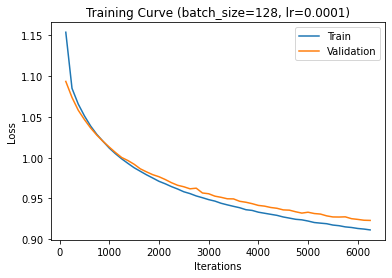

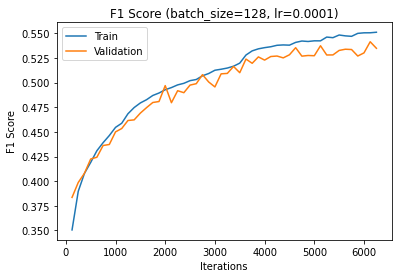

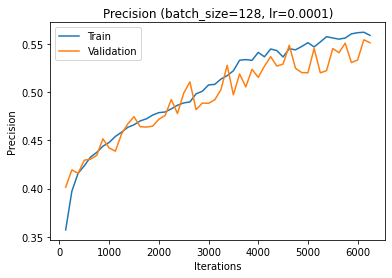

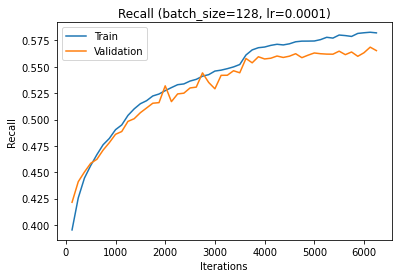

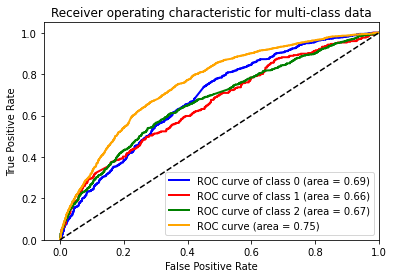

In [ ]:
#download glove dataset
!test -f ./glove.6B.50d.txt ||  ( wget http://nlp.stanford.edu/data/wordvecs/glove.6B.zip && unzip glove.6B.zip)
#download adabound
!pip3 install adabound

import re
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import nltk 
import re

from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.feature_extraction.text import  CountVectorizer
from sklearn.feature_extraction.text import  HashingVectorizer
from sklearn import metrics
from sklearn import preprocessing
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from numpy.ma.core import concatenate
from itertools import cycle
from adabound import AdaBound



glove = pd.read_csv('./glove.6B.50d.txt', sep=' ', index_col=0, header=None, quoting=3)
glove_embedding = {key: val.values for key, val in glove.T.items()}



data_train = pd.read_csv('./vaccine_train_set.csv')
data_val = pd.read_csv('./vaccine_validation_set.csv')

x_train = pd.DataFrame(data_train,columns=[data_train.columns[1]])
y_train = pd.DataFrame(data_train,columns=[data_train.columns[2]])

x_val =  pd.DataFrame(data_val,columns=[data_val.columns[1]])
y_val =  pd.DataFrame(data_val,columns=[data_val.columns[2]])

def create_array(tweet): #split tweet into array of its words
    return re.split(' ',tweet)

def transform(tweet):
    array = np.array(np.zeros([1,50]))
    for word in tweet:
        if word not in glove_embedding: #glove does not contain the word in the tweet, fill features with 0
            ar = np.zeros([1,50])
        else:
            ar = np.array([glove_embedding.get(word)]) #fill row features with glove's word embedding
        array = np.concatenate((array,ar)) #concatenate the word embedding with the tweet embedding
    return array

def sum_array(tweet): #sum the array of word embeddings to get the tweet embedding
    return np.sum(tweet, axis=0) 



#create,transform,sum the tweet embedding
#train set
x_train['tweet'] = x_train['tweet'].apply(lambda tweet:create_array(tweet))
x_train['tweet'] = x_train['tweet'].apply(lambda tweet:transform(tweet))
x_train['tweet'] = x_train['tweet'].apply(lambda tweet:sum_array(tweet))

#validation set
x_val['tweet'] = x_val['tweet'].apply(lambda tweet:create_array(tweet))
x_val['tweet'] = x_val['tweet'].apply(lambda tweet:transform(tweet))
x_val['tweet'] = x_val['tweet'].apply(lambda tweet:sum_array(tweet))



#create the train tensor 
x_train = torch.tensor(x_train['tweet'],dtype=torch.float)
k_train = np.array(y_train['label'])

y_train = torch.from_numpy(k_train)
# y_train = y_train.to(torch.long)

#create the validation tensor 
x_val = torch.tensor(x_val['tweet'],dtype=torch.float)
k_val = np.array(y_val['label'])

y_val = torch.from_numpy(k_val)



#Define the NN

class Net(nn.Module):
    def __init__(self, D_in, H1, D_out):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, D_out)

        self.dropout = nn.Dropout(0.7)
        
    def forward(self, x):
        h1 = self.linear1(x)
        act1 =  nn.functional.relu(h1)

        out = self.linear2(act1)
        return out

#Define layer sizes
D_in = x_train.shape[1]
H1 = 64
D_out = 3

#Define Hyperparameters
learning_rate = 0.0001

#Initialize model, loss, optimizer
model = Net(D_in, H1, D_out)
loss_func = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.8,weight_decay=0.0001)


#Initialize train dataloader
batch_size = 128
dataset_train = torch.utils.data.TensorDataset(x_train, y_train)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size, shuffle=True)


#Initialize validation dataloader
dataset_val = torch.utils.data.TensorDataset(x_val,y_val)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size, shuffle=True)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)


iterations,losses_train,losses_val,f1ScoresTrain,f1ScoresVal,recallTrain,recallVal,precisionTrain,precisionVal = [],[],[],[],[],[],[],[],[]
n = 0
for epoch in range(50):
  batch_losses_train = []
  batch_losses_val = []
  f1_batch_scores_train,f1_batch_scores_val = [],[]
  precision_batch_train,precision_batch_val = [],[]
  recall_batch_train,recall_batch_val = [],[]

  for x_batch, y_batch in dataloader_train:
    y_pred_train = model(x_batch)
    loss = loss_func(y_pred_train, y_batch)
    batch_losses_train.append(loss.item())

    #Delete previously stored gradients
    optimizer.zero_grad()
    #Perform backpropagation starting from the loss calculated in this epoch
    loss.backward()
    #Update model's weights based on the gradients calculated during backprop
    optimizer.step()
    n += 1

    model.eval()
    model_batch_result = nn.functional.softmax(y_pred_train,dim=1)
    y_pred = model_batch_result.cpu().max(1)[1].numpy()
    f1Score = metrics.f1_score(y_batch,y_pred,average='weighted')
    precision = metrics.precision_score(y_batch,y_pred,average='weighted',zero_division=0)
    recall = metrics.recall_score(y_batch,y_pred,average='weighted',zero_division=0)
    f1_batch_scores_train.append(f1Score)
    precision_batch_train.append(precision)
    recall_batch_train.append(recall)
  
  print(f'\nEpoch: {epoch:3}')
  print(f"(Training) - Loss = {sum(batch_losses_train)/len(dataloader_train):.5f}")
  print(f"(Training) - F1 Score = {sum(f1_batch_scores_train)/len(dataloader_train):.5f}")


  losses_train.append(sum(batch_losses_train)/len(dataloader_train))
  f1ScoresTrain.append(sum(f1_batch_scores_train)/len(dataloader_train))
  precisionTrain.append(sum(precision_batch_train)/len(dataloader_train))
  recallTrain.append(sum(recall_batch_train)/len(dataloader_train))
    

  #evaluate the model on the validation set
  for x_batch,y_batch in dataloader_val:
    y_pred_val = model(x_batch)
    loss_val = loss_func(y_pred_val,y_batch)
    batch_losses_val.append(loss_val.item())

    model.eval()
    model_batch_result = nn.functional.softmax(y_pred_val,dim=1)
    y_pred = model_batch_result.cpu().max(1)[1].numpy()
    f1Score = metrics.f1_score(y_batch,y_pred,average='weighted' )
    precision = metrics.precision_score(y_batch,y_pred,average='weighted',zero_division=0)
    recall = metrics.recall_score(y_batch,y_pred,average='weighted',zero_division=0)
    f1_batch_scores_val.append(f1Score)
    precision_batch_val.append(precision)
    recall_batch_val.append(recall)

  losses_val.append(sum(batch_losses_val)/len(dataloader_val))
  f1ScoresVal.append(sum(f1_batch_scores_val)/len(dataloader_val))
  precisionVal.append(sum(precision_batch_val)/len(dataloader_val))
  recallVal.append(sum(recall_batch_val)/len(dataloader_val))

  print(f"(Validation) - Loss = {sum(batch_losses_val)/len(dataloader_val):.5f}")
  print(f"(Validation) - F1 Score = {sum(f1_batch_scores_val)/len(dataloader_val):.5f}")

  iterations.append(n)
  # scheduler.step()



# Plotting

#Loss
plt.title("Training Curve (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, losses_train, label="Train")
plt.plot(iterations, losses_val, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

#F1 Score
plt.title("F1 Score (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, f1ScoresTrain, label="Train")
plt.plot(iterations, f1ScoresVal, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("F1 Score")
plt.legend(loc='best')
plt.show()

#Precision
plt.title("Precision (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, precisionTrain, label="Train")
plt.plot(iterations, precisionVal, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Precision")
plt.legend(loc='best')
plt.show()

#recall
plt.title("Recall (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, recallTrain, label="Train")
plt.plot(iterations, recallVal, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Recall")
plt.legend(loc='best')
plt.show()


#roc curve
y_val_roc = label_binarize(y_val, classes=[0, 1, 2])
fpr = dict()
tpr = dict()
roc_auc = dict()
y_val_roc = torch.tensor(y_val_roc)

y_pred_val = model(x_val)
sc = nn.functional.softmax(y_pred_val,dim=1)

for i in range(3):
  fpr[i], tpr[i], _ = roc_curve(y_val_roc.detach().numpy()[:, i], sc.detach().numpy()[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

fpr[3], tpr[3], _ = roc_curve(y_val_roc.detach().numpy().ravel(), sc.detach().numpy().ravel())
roc_auc[3] = auc(fpr[3], tpr[3])

colors = cycle(['blue', 'red', 'green','orange'])
for i, color in zip(range(4), colors):
  if(i == 3):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve (area = {0:0.2f})'
             ''.format(roc_auc[i]))
  else:
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()


# Default GloVe Model with Adabound Optimizer

- Glove 50d
- Optimizer : SGD
- Batch Size = 128
- Learning Rate : 1e-4
- Epochs : 50


DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


/var/folders/v9/0g473_2s1_7d8mjnpg8tx86r0000gn/T/ipykernel_1624/2214935844.py:76: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  x_train = torch.tensor(x_train['tweet'],dtype=torch.float)
/Library/Python/3.8/site-packages/adabound/adabound.py:94: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1050.)
  exp_avg.mul_(beta1).add_(1 - beta1, grad)



Epoch:   0
(Training) - Loss = 1.16209
(Training) - F1 Score = 0.46106
(Validation) - Loss = 0.96477
(Validation) - F1 Score = 0.52445

Epoch:   1
(Training) - Loss = 0.94666
(Training) - F1 Score = 0.53672
(Validation) - Loss = 0.94091
(Validation) - F1 Score = 0.52868

Epoch:   2
(Training) - Loss = 0.91693
(Training) - F1 Score = 0.54502
(Validation) - Loss = 0.91150
(Validation) - F1 Score = 0.54050

Epoch:   3
(Training) - Loss = 0.89084
(Training) - F1 Score = 0.55463
(Validation) - Loss = 0.88800
(Validation) - F1 Score = 0.54971

Epoch:   4
(Training) - Loss = 0.88303
(Training) - F1 Score = 0.56322
(Validation) - Loss = 0.90472
(Validation) - F1 Score = 0.54896

Epoch:   5
(Training) - Loss = 0.87040
(Training) - F1 Score = 0.56906
(Validation) - Loss = 0.86652
(Validation) - F1 Score = 0.55323

Epoch:   6
(Training) - Loss = 0.86412
(Training) - F1 Score = 0.57139
(Validation) - Loss = 0.89486
(Validation) - F1 Score = 0.52683

Epoch:   7
(Training) - Loss = 0.85987
(Trainin

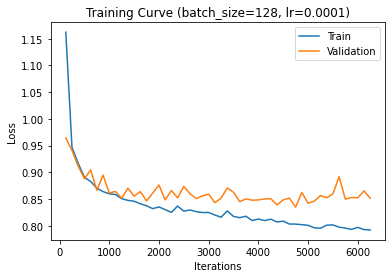

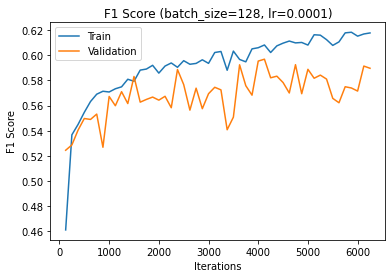

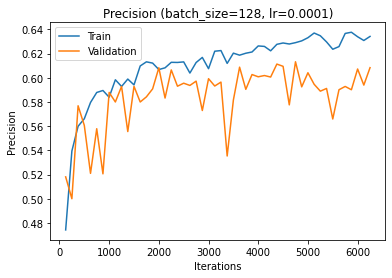

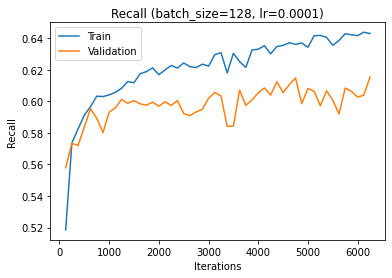

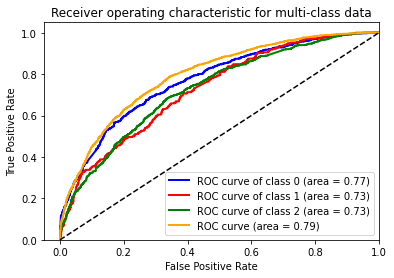

In [ ]:
#download glove dataset
!test -f ./glove.6B.50d.txt ||  ( wget http://nlp.stanford.edu/data/wordvecs/glove.6B.zip && unzip glove.6B.zip)
#download adabound
!pip3 install adabound

import re
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import nltk 
import re

from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.feature_extraction.text import  CountVectorizer
from sklearn.feature_extraction.text import  HashingVectorizer
from sklearn import metrics
from sklearn import preprocessing
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from numpy.ma.core import concatenate
from itertools import cycle
from adabound import AdaBound



glove = pd.read_csv('./glove.6B.50d.txt', sep=' ', index_col=0, header=None, quoting=3)
glove_embedding = {key: val.values for key, val in glove.T.items()}



data_train = pd.read_csv('./vaccine_train_set.csv')
data_val = pd.read_csv('./vaccine_validation_set.csv')

x_train = pd.DataFrame(data_train,columns=[data_train.columns[1]])
y_train = pd.DataFrame(data_train,columns=[data_train.columns[2]])

x_val =  pd.DataFrame(data_val,columns=[data_val.columns[1]])
y_val =  pd.DataFrame(data_val,columns=[data_val.columns[2]])

def create_array(tweet): #split tweet into array of its words
    return re.split(' ',tweet)

def transform(tweet):
    array = np.array(np.zeros([1,50]))
    for word in tweet:
        if word not in glove_embedding: #glove does not contain the word in the tweet, fill features with 0
            ar = np.zeros([1,50])
        else:
            ar = np.array([glove_embedding.get(word)]) #fill row features with glove's word embedding
        array = np.concatenate((array,ar)) #concatenate the word embedding with the tweet embedding
    return array

def sum_array(tweet): #sum the array of word embeddings to get the tweet embedding
    return np.sum(tweet, axis=0) 



#create,transform,sum the tweet embedding
#train set
x_train['tweet'] = x_train['tweet'].apply(lambda tweet:create_array(tweet))
x_train['tweet'] = x_train['tweet'].apply(lambda tweet:transform(tweet))
x_train['tweet'] = x_train['tweet'].apply(lambda tweet:sum_array(tweet))

#validation set
x_val['tweet'] = x_val['tweet'].apply(lambda tweet:create_array(tweet))
x_val['tweet'] = x_val['tweet'].apply(lambda tweet:transform(tweet))
x_val['tweet'] = x_val['tweet'].apply(lambda tweet:sum_array(tweet))



#create the train tensor 
x_train = torch.tensor(x_train['tweet'],dtype=torch.float)
k_train = np.array(y_train['label'])

y_train = torch.from_numpy(k_train)
# y_train = y_train.to(torch.long)

#create the validation tensor 
x_val = torch.tensor(x_val['tweet'],dtype=torch.float)
k_val = np.array(y_val['label'])

y_val = torch.from_numpy(k_val)



#Define the NN

class Net(nn.Module):
    def __init__(self, D_in, H1, D_out):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, D_out)

        self.dropout = nn.Dropout(0.7)
        
    def forward(self, x):
        h1 = self.linear1(x)
        act1 =  nn.functional.relu(h1)

        out = self.linear2(act1)
        return out

#Define layer sizes
D_in = x_train.shape[1]
H1 = 64
D_out = 3

#Define Hyperparameters
learning_rate = 0.0001

#Initialize model, loss, optimizer
model = Net(D_in, H1, D_out)
loss_func = nn.CrossEntropyLoss()

optimizer = AdaBound(model.parameters(), lr=learning_rate)


#Initialize train dataloader
batch_size = 128
dataset_train = torch.utils.data.TensorDataset(x_train, y_train)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size, shuffle=True)


#Initialize validation dataloader
dataset_val = torch.utils.data.TensorDataset(x_val,y_val)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size, shuffle=True)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)


iterations,losses_train,losses_val,f1ScoresTrain,f1ScoresVal,recallTrain,recallVal,precisionTrain,precisionVal = [],[],[],[],[],[],[],[],[]
n = 0
for epoch in range(50):
  batch_losses_train = []
  batch_losses_val = []
  f1_batch_scores_train,f1_batch_scores_val = [],[]
  precision_batch_train,precision_batch_val = [],[]
  recall_batch_train,recall_batch_val = [],[]

  for x_batch, y_batch in dataloader_train:
    y_pred_train = model(x_batch)
    loss = loss_func(y_pred_train, y_batch)
    batch_losses_train.append(loss.item())

    #Delete previously stored gradients
    optimizer.zero_grad()
    #Perform backpropagation starting from the loss calculated in this epoch
    loss.backward()
    #Update model's weights based on the gradients calculated during backprop
    optimizer.step()
    n += 1

    model.eval()
    model_batch_result = nn.functional.softmax(y_pred_train,dim=1)
    y_pred = model_batch_result.cpu().max(1)[1].numpy()
    f1Score = metrics.f1_score(y_batch,y_pred,average='weighted')
    precision = metrics.precision_score(y_batch,y_pred,average='weighted',zero_division=0)
    recall = metrics.recall_score(y_batch,y_pred,average='weighted',zero_division=0)
    f1_batch_scores_train.append(f1Score)
    precision_batch_train.append(precision)
    recall_batch_train.append(recall)
  
  print(f'\nEpoch: {epoch:3}')
  print(f"(Training) - Loss = {sum(batch_losses_train)/len(dataloader_train):.5f}")
  print(f"(Training) - F1 Score = {sum(f1_batch_scores_train)/len(dataloader_train):.5f}")


  losses_train.append(sum(batch_losses_train)/len(dataloader_train))
  f1ScoresTrain.append(sum(f1_batch_scores_train)/len(dataloader_train))
  precisionTrain.append(sum(precision_batch_train)/len(dataloader_train))
  recallTrain.append(sum(recall_batch_train)/len(dataloader_train))
    

  #evaluate the model on the validation set
  for x_batch,y_batch in dataloader_val:
    y_pred_val = model(x_batch)
    loss_val = loss_func(y_pred_val,y_batch)
    batch_losses_val.append(loss_val.item())

    model.eval()
    model_batch_result = nn.functional.softmax(y_pred_val,dim=1)
    y_pred = model_batch_result.cpu().max(1)[1].numpy()
    f1Score = metrics.f1_score(y_batch,y_pred,average='weighted' )
    precision = metrics.precision_score(y_batch,y_pred,average='weighted',zero_division=0)
    recall = metrics.recall_score(y_batch,y_pred,average='weighted',zero_division=0)
    f1_batch_scores_val.append(f1Score)
    precision_batch_val.append(precision)
    recall_batch_val.append(recall)

  losses_val.append(sum(batch_losses_val)/len(dataloader_val))
  f1ScoresVal.append(sum(f1_batch_scores_val)/len(dataloader_val))
  precisionVal.append(sum(precision_batch_val)/len(dataloader_val))
  recallVal.append(sum(recall_batch_val)/len(dataloader_val))

  print(f"(Validation) - Loss = {sum(batch_losses_val)/len(dataloader_val):.5f}")
  print(f"(Validation) - F1 Score = {sum(f1_batch_scores_val)/len(dataloader_val):.5f}")

  iterations.append(n)
  # scheduler.step()



# Plotting

#Loss
plt.title("Training Curve (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, losses_train, label="Train")
plt.plot(iterations, losses_val, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

#F1 Score
plt.title("F1 Score (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, f1ScoresTrain, label="Train")
plt.plot(iterations, f1ScoresVal, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("F1 Score")
plt.legend(loc='best')
plt.show()

#Precision
plt.title("Precision (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, precisionTrain, label="Train")
plt.plot(iterations, precisionVal, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Precision")
plt.legend(loc='best')
plt.show()

#recall
plt.title("Recall (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, recallTrain, label="Train")
plt.plot(iterations, recallVal, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Recall")
plt.legend(loc='best')
plt.show()


#roc curve
y_val_roc = label_binarize(y_val, classes=[0, 1, 2])
fpr = dict()
tpr = dict()
roc_auc = dict()
y_val_roc = torch.tensor(y_val_roc)

y_pred_val = model(x_val)
sc = nn.functional.softmax(y_pred_val,dim=1)

for i in range(3):
  fpr[i], tpr[i], _ = roc_curve(y_val_roc.detach().numpy()[:, i], sc.detach().numpy()[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

fpr[3], tpr[3], _ = roc_curve(y_val_roc.detach().numpy().ravel(), sc.detach().numpy().ravel())
roc_auc[3] = auc(fpr[3], tpr[3])

colors = cycle(['blue', 'red', 'green','orange'])
for i, color in zip(range(4), colors):
  if(i == 3):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve (area = {0:0.2f})'
             ''.format(roc_auc[i]))
  else:
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()


# Softmax Model with TFIDF Vectorizer 

**Optimizer : NAdam**

### Hyperparameters

- LR = 1e-4 
- Batch Size = 128,
- Epochs = 50

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621

Epoch:   0
(Training) - Loss = 1.09643
(Training) - F1 Score = 0.45510
(Validation) - Loss = 1.09282
(Validation) - F1 Score = 0.59510

Epoch:   1
(Training) - Loss = 1.08918
(Training) - F1 Score = 0.64763
(Validation) - Loss = 1.08656
(Validation) - F1 Score = 0.62311

Epoch:   2
(Training) - Loss = 1.08222
(Training) - F1 Score = 0.67886
(Validation) - Loss = 1.08064
(Validation) - F1 Score = 0.62810

Epoch:   3
(Training) - Loss = 1.07546
(Training) - F1 Score = 0.68886


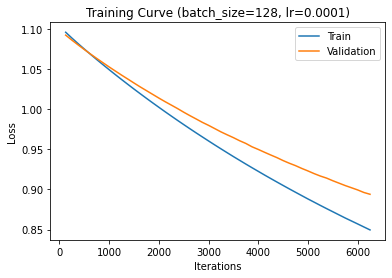

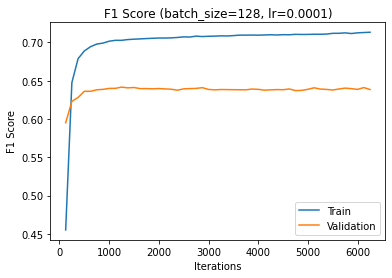

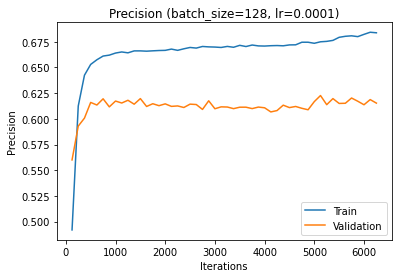

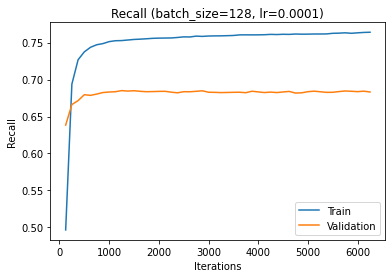

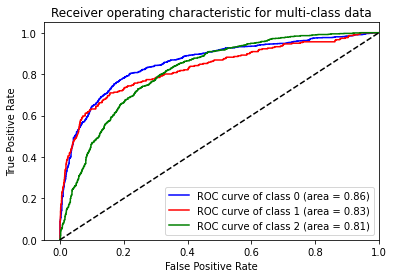

In [ ]:
#download glove dataset
!test -f ./glove.6B.50d.txt ||  ( wget http://nlp.stanford.edu/data/wordvecs/glove.6B.zip && unzip glove.6B.zip)
#download adabound
!pip3 install adabound

import re
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import nltk 
import re

from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.feature_extraction.text import  CountVectorizer
from sklearn.feature_extraction.text import  HashingVectorizer
from sklearn import metrics
from sklearn import preprocessing
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from numpy.ma.core import concatenate
from itertools import cycle
from adabound import AdaBound




data_train = pd.read_csv('./vaccine_train_set.csv')
data_val = pd.read_csv('./vaccine_validation_set.csv')

#Data Preprocessing
set_types = [data_train,data_val]

for set in set_types: 

    set['tweet'] = set['tweet'].dropna() #remove empty cells
    set['tweet'] = set['tweet'].str.replace('[_.!?\\-]', ' ',regex=True)#remove punctuation
    set['tweet'] = set['tweet'].str.replace('[0-9]+', '',regex=True) #remove numbers
    set['tweet'] = set['tweet'].str.lower() #lowercase
    set['tweet'] = set['tweet'].replace('\r\\n', ' ', regex=True)  #remove new line and carriage return
    set['tweet'] = set['tweet'].apply(lambda x: x.encode('ascii', 'ignore').decode('ascii')) #remove emojis
    set['tweet'] = set['tweet'].apply(lambda x: re.split('http:\/\/.*', str(x))[0])#remove links
    set['tweet'] = set['tweet'].replace('\s+', ' ', regex=True) #remove extra whitespaces
    set['tweet'] = set['tweet'].apply(nltk.word_tokenize) #tokenize words
    set['tweet'] = [' '.join(map(str, l)) for l in set['tweet']] #convert words from list to string


### Initialize Vectorizers & Regression
#Define Vectorizers
vectorizer = TfidfVectorizer(strip_accents='unicode', ngram_range=(1, 1), stop_words='english', lowercase=True)

y_train = data_train['label']
y_val = data_val['label']

#Create train and validation sets 
x_train = vectorizer.fit_transform(data_train['tweet'])
x_val = vectorizer.transform(data_val['tweet'])


y_train = torch.tensor(y_train,dtype=torch.float)
x_train = torch.tensor(x_train.toarray(),dtype=torch.float)
y_train = y_train.to(torch.long)

y_val = torch.tensor(y_val,dtype=torch.float)
x_val = torch.tensor(x_val.toarray(),dtype=torch.float)
y_val = y_val.to(torch.long)

y_train = nn.functional.one_hot(y_train,num_classes=3)
y_train = y_train.to(torch.float)
y_val = nn.functional.one_hot(y_val,num_classes=3)
y_val = y_val.to(torch.float)



#Define the NN

class Net(nn.Module):
    def __init__(self, D_in, D_out):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(D_in, D_out)

        self.dropout = nn.Dropout(0.7)
        
    def forward(self, x):
        h1 = self.linear1(x)
        out =  nn.functional.relu(h1)

        return out


#Define layer sizes
D_in = x_train.shape[1]
D_out = 3

#Define Hyperparameters
learning_rate = 0.0001

#Initialize model, loss, optimizer
model = Net(D_in, D_out)
loss_func = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.8,weight_decay=0.0001)
optimizer = torch.optim.NAdam(model.parameters(), lr=learning_rate)
# optimizer = AdaBound(model.parameters(), lr=learning_rate)

#Initialize train dataloader
batch_size = 128
dataset_train = torch.utils.data.TensorDataset(x_train, y_train)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size, shuffle=True)


#Initialize validation dataloader
dataset_val = torch.utils.data.TensorDataset(x_val,y_val)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size, shuffle=True)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

iterations,losses_train,losses_val,f1ScoresTrain,f1ScoresVal,recallTrain,recallVal,precisionTrain,precisionVal = [],[],[],[],[],[],[],[],[]
n = 0
for epoch in range(50):
  batch_losses_train = []
  batch_losses_val = []
  f1_batch_scores_train,f1_batch_scores_val = [],[]
  precision_batch_train,precision_batch_val = [],[]
  recall_batch_train,recall_batch_val = [],[]

  for x_batch, y_batch in dataloader_train:
    y_pred_train = model(x_batch)
    loss = loss_func(y_pred_train, y_batch)
    batch_losses_train.append(loss.item())

    #Delete previously stored gradients
    optimizer.zero_grad()
    #Perform backpropagation starting from the loss calculated in this epoch
    loss.backward()
    #Update model's weights based on the gradients calculated during backprop
    optimizer.step()
    n += 1

    model.eval()
    model_batch_result = nn.functional.softmax(y_pred_train,dim=1)

    y_gt = torch.argmax(y_batch,dim=1)
    model_batch_result = torch.argmax(model_batch_result,dim=1)

    # y_pred = model_batch_result.cpu().max(1)[1].numpy()
    f1Score = metrics.f1_score(y_gt,model_batch_result,average='weighted')
    precision = metrics.precision_score(y_gt,model_batch_result,average='weighted',zero_division=0)
    recall = metrics.recall_score(y_gt,model_batch_result,average='weighted',zero_division=0)
    f1_batch_scores_train.append(f1Score)
    precision_batch_train.append(precision)
    recall_batch_train.append(recall)
  
  print(f'\nEpoch: {epoch:3}')
  print(f"(Training) - Loss = {sum(batch_losses_train)/len(dataloader_train):.5f}")
  print(f"(Training) - F1 Score = {sum(f1_batch_scores_train)/len(dataloader_train):.5f}")


  losses_train.append(sum(batch_losses_train)/len(dataloader_train))
  f1ScoresTrain.append(sum(f1_batch_scores_train)/len(dataloader_train))
  precisionTrain.append(sum(precision_batch_train)/len(dataloader_train))
  recallTrain.append(sum(recall_batch_train)/len(dataloader_train))
    

  #evaluate the model on the validation set
  for x_batch,y_batch in dataloader_val:
    y_pred_val = model(x_batch)
    loss_val = loss_func(y_pred_val,y_batch)
    batch_losses_val.append(loss_val.item())

    model.eval()
    model_batch_result = nn.functional.softmax(y_pred_val,dim=1)

    y_gt = torch.argmax(y_batch,dim=1)
    model_batch_result = torch.argmax(model_batch_result,dim=1)

    f1Score = metrics.f1_score(y_gt,model_batch_result,average='weighted')
    precision = metrics.precision_score(y_gt,model_batch_result,average='weighted',zero_division=0)
    recall = metrics.recall_score(y_gt,model_batch_result,average='weighted',zero_division=0)
    f1_batch_scores_val.append(f1Score)
    precision_batch_val.append(precision)
    recall_batch_val.append(recall)

  losses_val.append(sum(batch_losses_val)/len(dataloader_val))
  f1ScoresVal.append(sum(f1_batch_scores_val)/len(dataloader_val))
  precisionVal.append(sum(precision_batch_val)/len(dataloader_val))
  recallVal.append(sum(recall_batch_val)/len(dataloader_val))

  print(f"(Validation) - Loss = {sum(batch_losses_val)/len(dataloader_val):.5f}")
  print(f"(Validation) - F1 Score = {sum(f1_batch_scores_val)/len(dataloader_val):.5f}")

  iterations.append(n)
  # scheduler.step()



# Plotting

#Loss
plt.title("Training Curve (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, losses_train, label="Train")
plt.plot(iterations, losses_val, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

#F1 Score
plt.title("F1 Score (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, f1ScoresTrain, label="Train")
plt.plot(iterations, f1ScoresVal, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("F1 Score")
plt.legend(loc='best')
plt.show()

#Precision
plt.title("Precision (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, precisionTrain, label="Train")
plt.plot(iterations, precisionVal, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Precision")
plt.legend(loc='best')
plt.show()

#recall
plt.title("Recall (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, recallTrain, label="Train")
plt.plot(iterations, recallVal, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Recall")
plt.legend(loc='best')
plt.show()


#roc curve
y_val_roc = label_binarize(y_val, classes=[0, 1, 2])
fpr = dict()
tpr = dict()
roc_auc = dict()
y_val_roc = torch.tensor(y_val_roc)

y_pred_val = model(x_val)
sc = nn.functional.softmax(y_pred_val,dim=1)

for i in range(3):
  fpr[i], tpr[i], _ = roc_curve(y_val_roc.detach().numpy()[:, i], sc.detach().numpy()[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1.5,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()


# Default Softmax Vectorized Model

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621

Epoch:   0
(Training) - Loss = 1.09117
(Training) - F1 Score = 0.52942
(Validation) - Loss = 1.08299
(Validation) - F1 Score = 0.61335

Epoch:   1
(Training) - Loss = 1.07224
(Training) - F1 Score = 0.64611
(Validation) - Loss = 1.06732
(Validation) - F1 Score = 0.63186

Epoch:   2
(Training) - Loss = 1.05392
(Training) - F1 Score = 0.66645
(Validation) - Loss = 1.05260
(Validation) - F1 Score = 0.63636

Epoch:   3
(Training) - Loss = 1.03636
(Training) - F1 Score = 0.67496


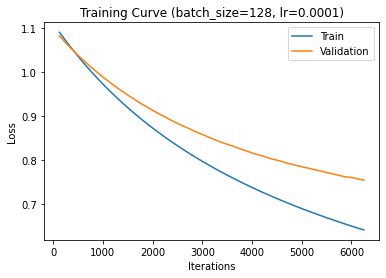

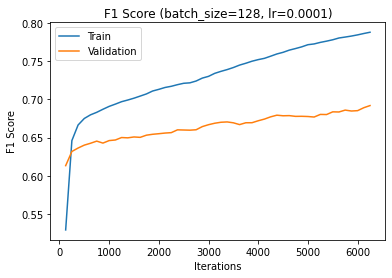

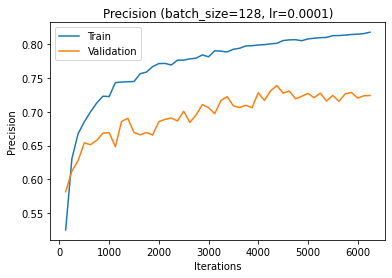

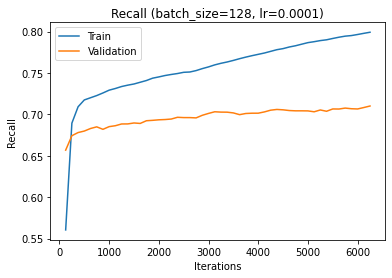

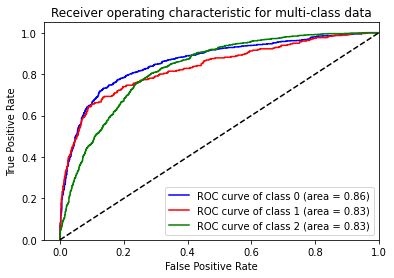

In [ ]:
#download glove dataset
!test -f ./glove.6B.50d.txt ||  ( wget http://nlp.stanford.edu/data/wordvecs/glove.6B.zip && unzip glove.6B.zip)
#download adabound
!pip3 install adabound

import re
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import nltk 
import re

from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.feature_extraction.text import  CountVectorizer
from sklearn.feature_extraction.text import  HashingVectorizer
from sklearn import metrics
from sklearn import preprocessing
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from numpy.ma.core import concatenate
from itertools import cycle
from adabound import AdaBound




data_train = pd.read_csv('./vaccine_train_set.csv')
data_val = pd.read_csv('./vaccine_validation_set.csv')

#Data Preprocessing
set_types = [data_train,data_val]

for set in set_types: 

    set['tweet'] = set['tweet'].dropna() #remove empty cells
    set['tweet'] = set['tweet'].str.replace('[_.!?\\-]', ' ',regex=True)#remove punctuation
    set['tweet'] = set['tweet'].str.replace('[0-9]+', '',regex=True) #remove numbers
    set['tweet'] = set['tweet'].str.lower() #lowercase
    set['tweet'] = set['tweet'].replace('\r\\n', ' ', regex=True)  #remove new line and carriage return
    set['tweet'] = set['tweet'].apply(lambda x: x.encode('ascii', 'ignore').decode('ascii')) #remove emojis
    set['tweet'] = set['tweet'].apply(lambda x: re.split('http:\/\/.*', str(x))[0])#remove links
    set['tweet'] = set['tweet'].replace('\s+', ' ', regex=True) #remove extra whitespaces
    set['tweet'] = set['tweet'].apply(nltk.word_tokenize) #tokenize words
    set['tweet'] = [' '.join(map(str, l)) for l in set['tweet']] #convert words from list to string


### Initialize Vectorizers & Regression
#Define Vectorizers
vectorizer = CountVectorizer(strip_accents='unicode', ngram_range=(1, 1), stop_words='english', lowercase=True)

y_train = data_train['label']
y_val = data_val['label']

#Create train and validation sets 
x_train = vectorizer.fit_transform(data_train['tweet'])
x_val = vectorizer.transform(data_val['tweet'])


y_train = torch.tensor(y_train,dtype=torch.float)
x_train = torch.tensor(x_train.toarray(),dtype=torch.float)
y_train = y_train.to(torch.long)

y_val = torch.tensor(y_val,dtype=torch.float)
x_val = torch.tensor(x_val.toarray(),dtype=torch.float)
y_val = y_val.to(torch.long)

y_train = nn.functional.one_hot(y_train,num_classes=3)
y_train = y_train.to(torch.float)
y_val = nn.functional.one_hot(y_val,num_classes=3)
y_val = y_val.to(torch.float)



#Define the NN

class Net(nn.Module):
    def __init__(self, D_in, D_out):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(D_in, D_out)

        self.dropout = nn.Dropout(0.7)
        
    def forward(self, x):
        h1 = self.linear1(x)
        out =  nn.functional.relu(h1)

        return out


#Define layer sizes
D_in = x_train.shape[1]
D_out = 3

#Define Hyperparameters
learning_rate = 0.0001

#Initialize model, loss, optimizer
model = Net(D_in, D_out)
loss_func = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.8,weight_decay=0.0001)
optimizer = torch.optim.NAdam(model.parameters(), lr=learning_rate)
# optimizer = AdaBound(model.parameters(), lr=learning_rate)

#Initialize train dataloader
batch_size = 128
dataset_train = torch.utils.data.TensorDataset(x_train, y_train)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size, shuffle=True)


#Initialize validation dataloader
dataset_val = torch.utils.data.TensorDataset(x_val,y_val)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size, shuffle=True)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

iterations,losses_train,losses_val,f1ScoresTrain,f1ScoresVal,recallTrain,recallVal,precisionTrain,precisionVal = [],[],[],[],[],[],[],[],[]
n = 0
for epoch in range(50):
  batch_losses_train = []
  batch_losses_val = []
  f1_batch_scores_train,f1_batch_scores_val = [],[]
  precision_batch_train,precision_batch_val = [],[]
  recall_batch_train,recall_batch_val = [],[]

  for x_batch, y_batch in dataloader_train:
    y_pred_train = model(x_batch)
    loss = loss_func(y_pred_train, y_batch)
    batch_losses_train.append(loss.item())

    #Delete previously stored gradients
    optimizer.zero_grad()
    #Perform backpropagation starting from the loss calculated in this epoch
    loss.backward()
    #Update model's weights based on the gradients calculated during backprop
    optimizer.step()
    n += 1

    model.eval()
    model_batch_result = nn.functional.softmax(y_pred_train,dim=1)

    y_gt = torch.argmax(y_batch,dim=1)
    model_batch_result = torch.argmax(model_batch_result,dim=1)

    # y_pred = model_batch_result.cpu().max(1)[1].numpy()
    f1Score = metrics.f1_score(y_gt,model_batch_result,average='weighted')
    precision = metrics.precision_score(y_gt,model_batch_result,average='weighted',zero_division=0)
    recall = metrics.recall_score(y_gt,model_batch_result,average='weighted',zero_division=0)
    f1_batch_scores_train.append(f1Score)
    precision_batch_train.append(precision)
    recall_batch_train.append(recall)
  
  print(f'\nEpoch: {epoch:3}')
  print(f"(Training) - Loss = {sum(batch_losses_train)/len(dataloader_train):.5f}")
  print(f"(Training) - F1 Score = {sum(f1_batch_scores_train)/len(dataloader_train):.5f}")


  losses_train.append(sum(batch_losses_train)/len(dataloader_train))
  f1ScoresTrain.append(sum(f1_batch_scores_train)/len(dataloader_train))
  precisionTrain.append(sum(precision_batch_train)/len(dataloader_train))
  recallTrain.append(sum(recall_batch_train)/len(dataloader_train))
    

  #evaluate the model on the validation set
  for x_batch,y_batch in dataloader_val:
    y_pred_val = model(x_batch)
    loss_val = loss_func(y_pred_val,y_batch)
    batch_losses_val.append(loss_val.item())

    model.eval()
    model_batch_result = nn.functional.softmax(y_pred_val,dim=1)

    y_gt = torch.argmax(y_batch,dim=1)
    model_batch_result = torch.argmax(model_batch_result,dim=1)

    f1Score = metrics.f1_score(y_gt,model_batch_result,average='weighted')
    precision = metrics.precision_score(y_gt,model_batch_result,average='weighted',zero_division=0)
    recall = metrics.recall_score(y_gt,model_batch_result,average='weighted',zero_division=0)
    f1_batch_scores_val.append(f1Score)
    precision_batch_val.append(precision)
    recall_batch_val.append(recall)

  losses_val.append(sum(batch_losses_val)/len(dataloader_val))
  f1ScoresVal.append(sum(f1_batch_scores_val)/len(dataloader_val))
  precisionVal.append(sum(precision_batch_val)/len(dataloader_val))
  recallVal.append(sum(recall_batch_val)/len(dataloader_val))

  print(f"(Validation) - Loss = {sum(batch_losses_val)/len(dataloader_val):.5f}")
  print(f"(Validation) - F1 Score = {sum(f1_batch_scores_val)/len(dataloader_val):.5f}")

  iterations.append(n)
  # scheduler.step()



# Plotting

#Loss
plt.title("Training Curve (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, losses_train, label="Train")
plt.plot(iterations, losses_val, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

#F1 Score
plt.title("F1 Score (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, f1ScoresTrain, label="Train")
plt.plot(iterations, f1ScoresVal, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("F1 Score")
plt.legend(loc='best')
plt.show()

#Precision
plt.title("Precision (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, precisionTrain, label="Train")
plt.plot(iterations, precisionVal, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Precision")
plt.legend(loc='best')
plt.show()

#recall
plt.title("Recall (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, recallTrain, label="Train")
plt.plot(iterations, recallVal, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Recall")
plt.legend(loc='best')
plt.show()


#roc curve
y_val_roc = label_binarize(y_val, classes=[0, 1, 2])
fpr = dict()
tpr = dict()
roc_auc = dict()
y_val_roc = torch.tensor(y_val_roc)

y_pred_val = model(x_val)
sc = nn.functional.softmax(y_pred_val,dim=1)

for i in range(3):
  fpr[i], tpr[i], _ = roc_curve(y_val_roc.detach().numpy()[:, i], sc.detach().numpy()[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1.5,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()


# Default GloVe Model

- Glove 50d
- Optimizer : NAdam
- Batch Size = 128
- Learning Rate : 1e-4
- Epochs : 50


DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


/var/folders/v9/0g473_2s1_7d8mjnpg8tx86r0000gn/T/ipykernel_2278/1598501050.py:76: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  x_train = torch.tensor(x_train['tweet'],dtype=torch.float)



Epoch:   0
(Training) - Loss = 1.33482
(Training) - F1 Score = 0.28867
(Validation) - Loss = 1.07345
(Validation) - F1 Score = 0.44530

Epoch:   1
(Training) - Loss = 1.04880
(Training) - F1 Score = 0.48147
(Validation) - Loss = 1.02529
(Validation) - F1 Score = 0.49492

Epoch:   2
(Training) - Loss = 1.00464
(Training) - F1 Score = 0.50904
(Validation) - Loss = 0.98593
(Validation) - F1 Score = 0.51306

Epoch:   3
(Training) - Loss = 0.96716
(Training) - F1 Score = 0.52746
(Validation) - Loss = 0.95259
(Validation) - F1 Score = 0.53050

Epoch:   4
(Training) - Loss = 0.93826
(Training) - F1 Score = 0.54639
(Validation) - Loss = 0.92998
(Validation) - F1 Score = 0.54535

Epoch:   5
(Training) - Loss = 0.91997
(Training) - F1 Score = 0.55703
(Validation) - Loss = 0.91636
(Validation) - F1 Score = 0.54423

Epoch:   6
(Training) - Loss = 0.90726
(Training) - F1 Score = 0.55976
(Validation) - Loss = 0.90782
(Validation) - F1 Score = 0.55211

Epoch:   7
(Training) - Loss = 0.89719
(Trainin

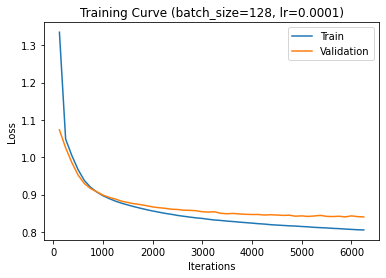

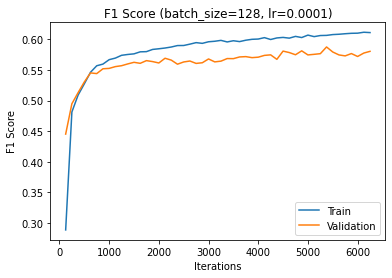

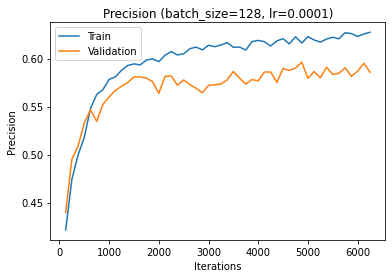

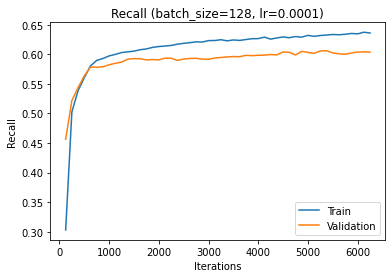

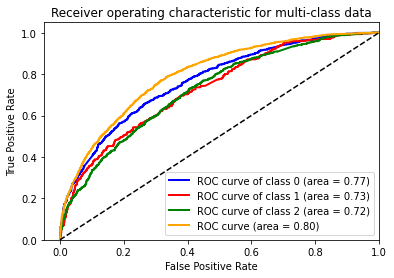

In [ ]:
#download glove dataset
!test -f ./glove.6B.50d.txt ||  ( wget http://nlp.stanford.edu/data/wordvecs/glove.6B.zip && unzip glove.6B.zip)
#download adabound
!pip3 install adabound

import re
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import nltk 
import re

from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.feature_extraction.text import  CountVectorizer
from sklearn.feature_extraction.text import  HashingVectorizer
from sklearn import metrics
from sklearn import preprocessing
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from numpy.ma.core import concatenate
from itertools import cycle
from adabound import AdaBound



glove = pd.read_csv('./glove.6B.50d.txt', sep=' ', index_col=0, header=None, quoting=3)
glove_embedding = {key: val.values for key, val in glove.T.items()}



data_train = pd.read_csv('./vaccine_train_set.csv')
data_val = pd.read_csv('./vaccine_validation_set.csv')

x_train = pd.DataFrame(data_train,columns=[data_train.columns[1]])
y_train = pd.DataFrame(data_train,columns=[data_train.columns[2]])

x_val =  pd.DataFrame(data_val,columns=[data_val.columns[1]])
y_val =  pd.DataFrame(data_val,columns=[data_val.columns[2]])

def create_array(tweet): #split tweet into array of its words
    return re.split(' ',tweet)

def transform(tweet):
    array = np.array(np.zeros([1,50]))
    for word in tweet:
        if word not in glove_embedding: #glove does not contain the word in the tweet, fill features with 0
            ar = np.zeros([1,50])
        else:
            ar = np.array([glove_embedding.get(word)]) #fill row features with glove's word embedding
        array = np.concatenate((array,ar)) #concatenate the word embedding with the tweet embedding
    return array

def sum_array(tweet): #sum the array of word embeddings to get the tweet embedding
    return np.sum(tweet, axis=0) 



#create,transform,sum the tweet embedding
#train set
x_train['tweet'] = x_train['tweet'].apply(lambda tweet:create_array(tweet))
x_train['tweet'] = x_train['tweet'].apply(lambda tweet:transform(tweet))
x_train['tweet'] = x_train['tweet'].apply(lambda tweet:sum_array(tweet))

#validation set
x_val['tweet'] = x_val['tweet'].apply(lambda tweet:create_array(tweet))
x_val['tweet'] = x_val['tweet'].apply(lambda tweet:transform(tweet))
x_val['tweet'] = x_val['tweet'].apply(lambda tweet:sum_array(tweet))



#create the train tensor 
x_train = torch.tensor(x_train['tweet'],dtype=torch.float)
k_train = np.array(y_train['label'])

y_train = torch.from_numpy(k_train)
# y_train = y_train.to(torch.long)

#create the validation tensor 
x_val = torch.tensor(x_val['tweet'],dtype=torch.float)
k_val = np.array(y_val['label'])

y_val = torch.from_numpy(k_val)



#Define the NN

class Net(nn.Module):
    def __init__(self, D_in, H1, D_out):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, D_out)

        self.dropout = nn.Dropout(0.7)
        
    def forward(self, x):
        h1 = self.linear1(x)
        act1 =  nn.functional.relu(h1)

        out = self.linear2(act1)
        return out

#Define layer sizes
D_in = x_train.shape[1]
H1 = 64
D_out = 3

#Define Hyperparameters
learning_rate = 0.0001

#Initialize model, loss, optimizer
model = Net(D_in, H1, D_out)
loss_func = nn.CrossEntropyLoss()

optimizer = torch.optim.NAdam(model.parameters(), lr=learning_rate)


#Initialize train dataloader
batch_size = 128
dataset_train = torch.utils.data.TensorDataset(x_train, y_train)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size, shuffle=True)


#Initialize validation dataloader
dataset_val = torch.utils.data.TensorDataset(x_val,y_val)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size, shuffle=True)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)


iterations,losses_train,losses_val,f1ScoresTrain,f1ScoresVal,recallTrain,recallVal,precisionTrain,precisionVal = [],[],[],[],[],[],[],[],[]
n = 0
for epoch in range(50):
  batch_losses_train = []
  batch_losses_val = []
  f1_batch_scores_train,f1_batch_scores_val = [],[]
  precision_batch_train,precision_batch_val = [],[]
  recall_batch_train,recall_batch_val = [],[]

  for x_batch, y_batch in dataloader_train:
    y_pred_train = model(x_batch)
    loss = loss_func(y_pred_train, y_batch)
    batch_losses_train.append(loss.item())

    #Delete previously stored gradients
    optimizer.zero_grad()
    #Perform backpropagation starting from the loss calculated in this epoch
    loss.backward()
    #Update model's weights based on the gradients calculated during backprop
    optimizer.step()
    n += 1

    model.eval()
    model_batch_result = nn.functional.softmax(y_pred_train,dim=1)
    y_pred = model_batch_result.cpu().max(1)[1].numpy()
    f1Score = metrics.f1_score(y_batch,y_pred,average='weighted')
    precision = metrics.precision_score(y_batch,y_pred,average='weighted',zero_division=0)
    recall = metrics.recall_score(y_batch,y_pred,average='weighted',zero_division=0)
    f1_batch_scores_train.append(f1Score)
    precision_batch_train.append(precision)
    recall_batch_train.append(recall)
  
  print(f'\nEpoch: {epoch:3}')
  print(f"(Training) - Loss = {sum(batch_losses_train)/len(dataloader_train):.5f}")
  print(f"(Training) - F1 Score = {sum(f1_batch_scores_train)/len(dataloader_train):.5f}")


  losses_train.append(sum(batch_losses_train)/len(dataloader_train))
  f1ScoresTrain.append(sum(f1_batch_scores_train)/len(dataloader_train))
  precisionTrain.append(sum(precision_batch_train)/len(dataloader_train))
  recallTrain.append(sum(recall_batch_train)/len(dataloader_train))
    

  #evaluate the model on the validation set
  for x_batch,y_batch in dataloader_val:
    y_pred_val = model(x_batch)
    loss_val = loss_func(y_pred_val,y_batch)
    batch_losses_val.append(loss_val.item())

    model.eval()
    model_batch_result = nn.functional.softmax(y_pred_val,dim=1)
    y_pred = model_batch_result.cpu().max(1)[1].numpy()
    f1Score = metrics.f1_score(y_batch,y_pred,average='weighted' )
    precision = metrics.precision_score(y_batch,y_pred,average='weighted',zero_division=0)
    recall = metrics.recall_score(y_batch,y_pred,average='weighted',zero_division=0)
    f1_batch_scores_val.append(f1Score)
    precision_batch_val.append(precision)
    recall_batch_val.append(recall)

  losses_val.append(sum(batch_losses_val)/len(dataloader_val))
  f1ScoresVal.append(sum(f1_batch_scores_val)/len(dataloader_val))
  precisionVal.append(sum(precision_batch_val)/len(dataloader_val))
  recallVal.append(sum(recall_batch_val)/len(dataloader_val))

  print(f"(Validation) - Loss = {sum(batch_losses_val)/len(dataloader_val):.5f}")
  print(f"(Validation) - F1 Score = {sum(f1_batch_scores_val)/len(dataloader_val):.5f}")

  iterations.append(n)
  # scheduler.step()



# Plotting

#Loss
plt.title("Training Curve (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, losses_train, label="Train")
plt.plot(iterations, losses_val, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

#F1 Score
plt.title("F1 Score (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, f1ScoresTrain, label="Train")
plt.plot(iterations, f1ScoresVal, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("F1 Score")
plt.legend(loc='best')
plt.show()

#Precision
plt.title("Precision (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, precisionTrain, label="Train")
plt.plot(iterations, precisionVal, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Precision")
plt.legend(loc='best')
plt.show()

#recall
plt.title("Recall (batch_size={}, lr={})".format(batch_size, learning_rate))
plt.plot(iterations, recallTrain, label="Train")
plt.plot(iterations, recallVal, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Recall")
plt.legend(loc='best')
plt.show()


#roc curve
y_val_roc = label_binarize(y_val, classes=[0, 1, 2])
fpr = dict()
tpr = dict()
roc_auc = dict()
y_val_roc = torch.tensor(y_val_roc)

y_pred_val = model(x_val)
sc = nn.functional.softmax(y_pred_val,dim=1)

for i in range(3):
  fpr[i], tpr[i], _ = roc_curve(y_val_roc.detach().numpy()[:, i], sc.detach().numpy()[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

fpr[3], tpr[3], _ = roc_curve(y_val_roc.detach().numpy().ravel(), sc.detach().numpy().ravel())
roc_auc[3] = auc(fpr[3], tpr[3])

colors = cycle(['blue', 'red', 'green','orange'])
for i, color in zip(range(4), colors):
  if(i == 3):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve (area = {0:0.2f})'
             ''.format(roc_auc[i]))
  else:
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()
